# Projet 6 : Classifiez automatiquement des biens de consommation


# Traitement avec techniques récentes

<a id="0"></a> <br>
# Table of Contents 

1. [Traitement des données textuelles : Word/sentence embedding](#1)
    * [1.1 Word2vec](#2)
    * [1.2 BERT HuggingFace](#3)
    * [1.3 BERT Tensorflow hub](#4)
    * [1.4 USE : Universal Sentence Encoder](#5)

2. [Traitement des données visuelles](#6)

3. [Combinaison du traitement des données textuelles et des données visuelles](#7)

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import P6_fonctions as fc
import importlib
import pickle
from IPython.display import display
from sklearn.decomposition import PCA
import gensim as gs
import tensorflow as tf
from sklearn import cluster, metrics

import tensorflow.keras as tf
import transformers
from transformers import TFAutoModel, AutoTokenizer

import tensorflow_hub as hub

from os import listdir
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array

from keras.applications.vgg16 import preprocess_input


In [92]:
importlib.reload(fc)

<module 'P6_fonctions' from '/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 6/à zip/P6_fonctions.py'>

In [61]:
df_cat = pd.read_csv('data_text_clean.csv')

In [8]:
df_cat.head()

Unnamed: 0                           uniq_id            crawl_timestamp  \
0           0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56+00:00   
1           1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56+00:00   
2           2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56+00:00   
3           3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52+00:00   
4           4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52+00:00   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  ...  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  ...   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg  ...   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg  ...   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg  ...   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg  ...   

              cat_3 label                                          descr_bow  \
0          Curtains     4  key features elegance polyester multicolor abs...   
1  Baby Bath Towels     0  specifications sathiyas cotton bath towel bath...   
2  Baby Bath Towels     0  key features eurospa cotton terry face towel s...   
3         Bedsheets     4  key features santosh royal fashion cotton prin...   
4         Bedsheets     4  key features jaipur print cotton floral king s...   

  length_bow                                      descr_bow_lem  \
0        156  key feature elegance polyester multicolor abst...   
1         63  specification sathiyas cotton bath towel bath ...   
2        158  key feature eurospa cotton terry face towel se...   
3        114  key feature santosh royal fashion cotton print...   
4        156  key feature jaipur print cotton floral king si...   

  length_bow_lem                                     descr_bow_stem  \
0            156  key featur eleg polyest multicolor abstract ey...   
1             63  specif sathiya cotton bath towel bath towel re...   
2            158  key featur eurospa cotton terri face towel set...   
3            114  key featur santosh royal fashion cotton print ...   
4            156  key featur jaipur print cotton floral king siz...   

  length_bow_stem                                           descr_dl  \
0             156  key features of elegance polyester multicolor ...   
1              63  specifications of sathiyas cotton bath towel (...   
2             158  key features of eurospa cotton terry face towe...   
3             114  key features of santosh royal fashion cotton p...   
4             156  key features of jaipur print cotton floral kin...   

   length_dl  
0        248  
1         84  
2        253  
3        151  
4        232  

[5 rows x 28 columns]

In [62]:
liste_cat = ['Baby Care','Beauty and Personal Care','Computers','Home Decor & Festive Needs',
            'Home Furnishing','Kitchen & Dining','Watches']

In [94]:
path_images = "Flipkart/Images/"
list_photos = [file for file in listdir(path_images)]

# <a id="1"></a> 1. Traitement des données textuelles : Word/sentence embedding

Le word/sentence embedding est une technique de traitement du langage naturel qui permet de représenter les mots et les phrases sous forme de vecteurs numériques. Il attribue à chaque mot ou phrase un vecteur qui capture des caractéristiques sémantiques et syntaxiques de la langue.

## <a id="2"></a> 1.1 Word2vec

Word2Vec est un algorithme d'apprentissage automatique pour la création d'embeddings de mots. Il est basé sur un réseau de neurones artificiels, qui apprend à prédire les mots voisins d'un mot donné dans un corpus de textes. 

In [9]:
descriptions = df_cat['descr_bow_lem'].to_list()
descriptions = [gs.utils.simple_preprocess(text) for text in descriptions]

In [ ]:
print("max length bow lem : ", df_cat['length_bow_lem'].max())

max length bow lem :  379


In [11]:
# Déterminer les paramètres
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 380

In [ ]:
print("Création et entraînement du modèle Word2Vec.")
w2v_model = gs.models.Word2Vec(min_count=w2v_min_count,
                               window=w2v_window,
                               vector_size=w2v_size,
                               seed=0)


w2v_model.build_vocab(descriptions)
w2v_model.train(descriptions, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
w2v_words = w2v_model.wv.index_to_key
print("Taille du vocabulaire :", len(w2v_words))
print("Word2Vec entrainé.")

Création et entraînement du modèle Word2Vec.
Taille du vocabulaire : 4756
Word2Vec entrainé.


In [ ]:
# Export du modèle
with open('models/word2vec', 'wb') as f1:
    pickle.dump(w2v_model, f1)

In [ ]:
w2v_model.wv.most_similar(positive=["baby"])

[('striped', 0.5752667784690857),
 ('romper', 0.5393721461296082),
 ('babeezworld', 0.5285194516181946),
 ('cotton', 0.5202795267105103),
 ('waist', 0.5140923261642456),
 ('solid', 0.5075100064277649),
 ('dress', 0.49932020902633667),
 ('girl', 0.4946599304676056),
 ('summer', 0.4926302134990692),
 ('sleepsuit', 0.48282480239868164)]

In [ ]:
w2v_model.wv.most_similar(positive=["watche"])

[('fancy', 0.8770182132720947),
 ('dynos', 0.6984226703643799),
 ('wrist', 0.6822507977485657),
 ('beautifull', 0.6760491728782654),
 ('going', 0.611656904220581),
 ('stylish', 0.6027125120162964),
 ('official', 0.601153552532196),
 ('excitement', 0.5955184102058411),
 ('identity', 0.5723127126693726),
 ('comfortable', 0.5590385794639587)]

In [ ]:
w2v_model.wv.most_similar(positive=["computer"])

[('xyz', 0.8139210939407349),
 ('vacuum', 0.8081843852996826),
 ('connect', 0.7914854288101196),
 ('shopfloor', 0.7590823173522949),
 ('port', 0.7287194132804871),
 ('attachment', 0.7263138890266418),
 ('crevice', 0.7244979739189148),
 ('sf', 0.7180601358413696),
 ('beloved', 0.714545726776123),
 ('cleaning', 0.7106484770774841)]

In [ ]:
w2v_model.wv.most_similar(positive=["beauty"])

[('ordering', 0.7637093663215637),
 ('catering', 0.7632766962051392),
 ('beat', 0.7548701167106628),
 ('oxy', 0.7484097480773926),
 ('problem', 0.7015243172645569),
 ('cosmetic', 0.6981712579727173),
 ('immediately', 0.6736171245574951),
 ('grace', 0.657852053642273),
 ('adding', 0.619616687297821),
 ('furniture', 0.619522213935852)]

In [ ]:
w2v_model.wv.most_similar(positive=["home"])

[('office', 0.48431432247161865),
 ('décor', 0.4743858873844147),
 ('enhancing', 0.46201249957084656),
 ('appeal', 0.4489041268825531),
 ('elegance', 0.443427175283432),
 ('furniture', 0.43806177377700806),
 ('garden', 0.4379756450653076),
 ('mosaic', 0.4254302382469177),
 ('interior', 0.4217514395713806),
 ('upgrade', 0.42101895809173584)]

In [12]:
print("Préparation des descriptions")
tokenizer = tf.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(descriptions)
x_sentences = tf.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(descriptions),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: ", num_words)

Préparation des descriptions
Number of unique words:  4757


In [ ]:
print("Création de la matrice d'embedding")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = w2v_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = w2v_model.wv[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Création de la matrice d'embedding
Word embedding rate :  1.0
Embedding matrix: (4757, 300)


In [ ]:
# Création du modèle

input=tf.layers.Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=tf.layers.Input(shape=(maxlen,),dtype='float64')  
word_embedding=tf.layers.Embedding(input_dim=vocab_size,
                                   output_dim=w2v_size,
                                   weights = [embedding_matrix],
                                   input_length=maxlen)(word_input)
word_vec=tf.layers.GlobalAveragePooling1D()(word_embedding)  
embed_model = tf.models.Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380)]             0         
                                                                 
 embedding (Embedding)       (None, 380, 300)          1427100   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,427,100
Trainable params: 1,427,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
embed_model.save('w2v_embedding_model.keras')

In [6]:
embed_model = tf.models.load_model('models/w2v_embedding_model.keras')

Metal device set to: Apple M2


In [13]:
# Exécution du modèle
embeddings = embed_model.predict(x_sentences)
embeddings.shape

2023-05-01 12:21:15.710242: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


33/33 [==============================] - 1s 2ms/step


(1050, 300)

In [24]:
ARI_w2v, X_tsne_w2v, labels_w2v = fc.ARI_fct_tsne(embeddings, liste_cat, df_cat["label"])

ARI :  0.3585 time :  5.0


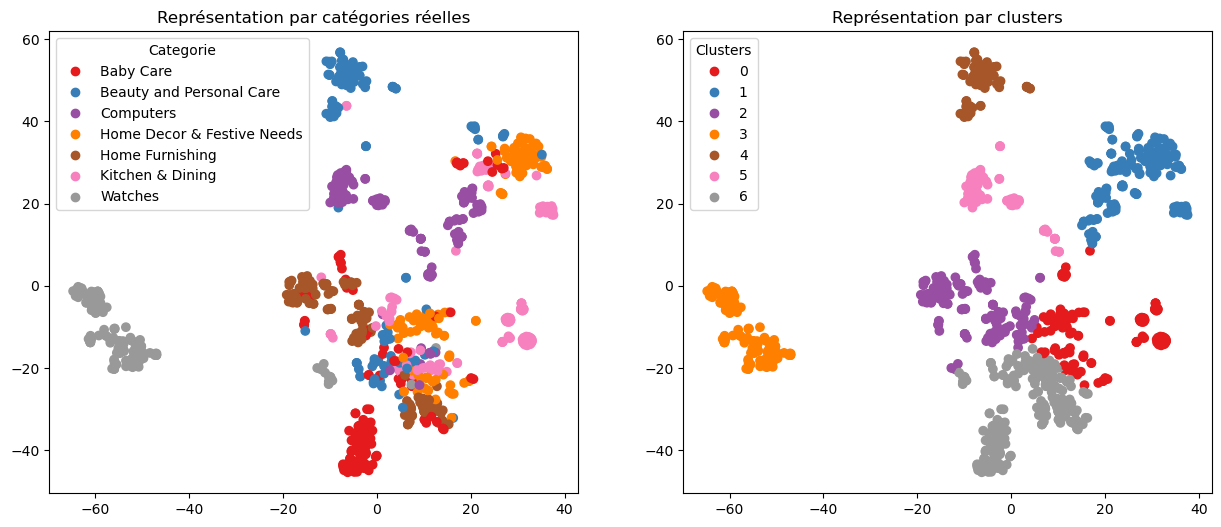

ARI :  0.3585


In [16]:
fc.TSNE_visu_fct(X_tsne_w2v, liste_cat, df_cat["label"], labels_w2v, ARI_w2v)

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. En effet, on constate que la plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme *Watches*, *Beauty and Personal Care* et *Computers*.

Ici nous obtenons un ARI à 0.3585.

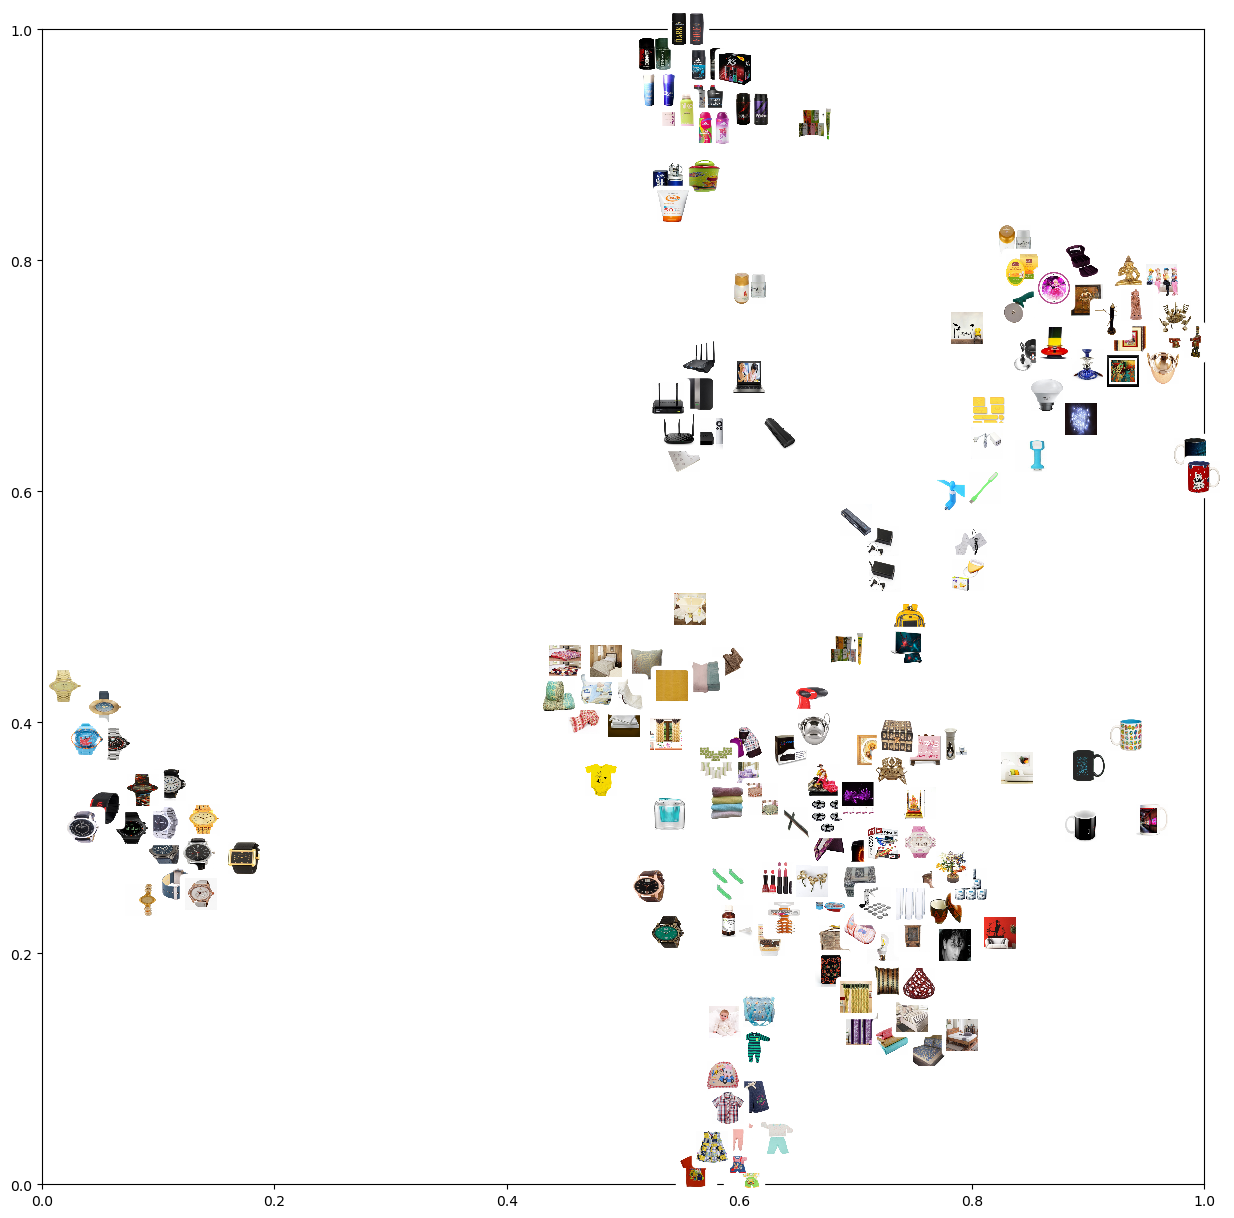

In [95]:
fc.plot_TSNE_images(X_tsne_w2v, df_cat, path_images)

On affiche une partie des images sur la visualisation 2D avec les données TSNE calculées précédemment. On constate que certaines catégories sont bien regroupées et séparées à certains endroits. Par exemple, on retrouve des montres  à gauche, des produits de beauté en haut, des produits pour bébé en bas, ou encore du matériel électronique en haut. Au centre, les catégories sont mélangées.


Visualisons désormais la réduction de dimension via une ACP.

In [17]:
pca = PCA()
pca.fit(embeddings)

PCA()

In [18]:
pca.explained_variance_ratio_.cumsum()

array([0.25749457, 0.40417656, 0.54660654, 0.6063481 , 0.64678365,
       0.68621814, 0.7240365 , 0.75285083, 0.7778721 , 0.80034107,
       0.82023966, 0.83695716, 0.85269284, 0.86623   , 0.87890446,
       0.8895826 , 0.89961994, 0.9080888 , 0.91578835, 0.9227812 ,
       0.92949265, 0.9355487 , 0.9408248 , 0.94557714, 0.94991183,
       0.9540038 , 0.9575906 , 0.96084535, 0.963672  , 0.9664051 ,
       0.9688448 , 0.9710499 , 0.97314745, 0.9752099 , 0.97704023,
       0.978745  , 0.9801659 , 0.9815014 , 0.9827787 , 0.98393106,
       0.98507196, 0.986072  , 0.98690283, 0.98770833, 0.9884158 ,
       0.9890673 , 0.9896979 , 0.9902389 , 0.9907545 , 0.9912402 ,
       0.9916945 , 0.9921224 , 0.99253505, 0.9929274 , 0.99329   ,
       0.99364734, 0.9939917 , 0.9942938 , 0.99457014, 0.9948363 ,
       0.99509466, 0.99534327, 0.9955905 , 0.99581534, 0.9960316 ,
       0.996238  , 0.99643856, 0.996618  , 0.9967891 , 0.9969566 ,
       0.99711204, 0.9972663 , 0.9974024 , 0.997533  , 0.99766

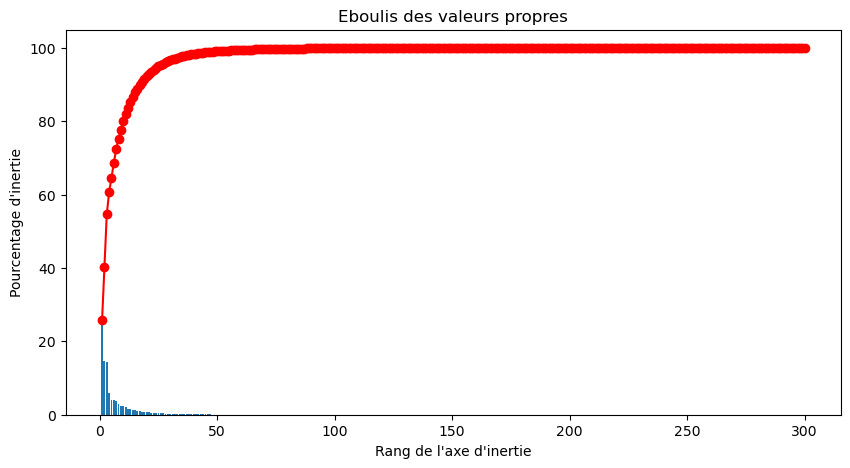

In [20]:
fc.eboulis(pca)

Les deux premières composantes de la PCA n'expliquent que 40% de la variance expliquée. Nous perdrions beaucoup d'information si nous décidions de n'utiliser que ces 2 premières composantes.

Nous allons donc réaliser une ACP afin de réduire nos dimensions puis ensuite réaliser un TSNE sur cette réduction. 

**Réduction de dimension ACP :**

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%).
L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [21]:
print("Dimensions dataset avant réduction PCA : ", embeddings.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(embeddings)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 300)
Dimensions dataset après réduction PCA :  (1050, 48)


In [22]:
ARI_w2v, X_tsne_w2v, labels_w2v = fc.ARI_fct_tsne(feat_pca, liste_cat, df_cat["label"])

ARI :  0.3289 time :  5.0


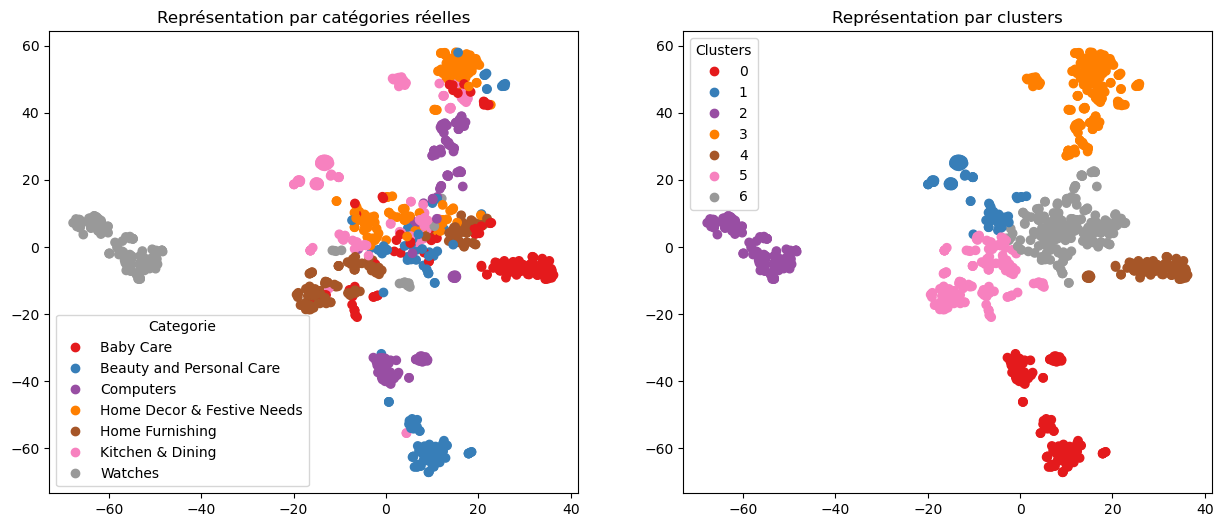

ARI :  0.3289


In [23]:
fc.TSNE_visu_fct(X_tsne_w2v, liste_cat, df_cat["label"], labels_w2v, ARI_w2v)

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. En effet, on constate que la plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme *Watches* ou *Baby Care*.

Ici nous obtenons un ARI inférieur à 0.3289.

**Analyse par classes**

In [25]:
conf_mat = metrics.confusion_matrix(df_cat["label"], labels_w2v)
conf_mat

array([[  5,  14,  28,   0,   0,   0, 103],
       [  3,  14,  11,   0,  86,   4,  32],
       [ 17,  41,   1,   0,   0,  86,   5],
       [ 43,  76,   7,   0,   0,   0,  24],
       [  0,   0, 103,   0,   0,   0,  47],
       [ 66,  48,  20,   0,   2,   0,  14],
       [  1,   0,   4, 134,   0,   0,  11]])

In [26]:
corresp = 'argmax'
cls_labels_transform = fc.conf_mat_transform(df_cat["label"], labels_w2v, corresp)
conf_mat = metrics.confusion_matrix(df_cat["label"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(df_cat["label"], cls_labels_transform))

Correspondance des clusters :  [5 3 4 6 1 2 0]
[[103   0   0  14  28   5   0]
 [ 32  86   4  14  11   3   0]
 [  5   0  86  41   1  17   0]
 [ 24   0   0  76   7  43   0]
 [ 47   0   0   0 103   0   0]
 [ 14   2   0  48  20  66   0]
 [ 11   0   0   0   4   1 134]]

              precision    recall  f1-score   support

           0       0.44      0.69      0.53       150
           1       0.98      0.57      0.72       150
           2       0.96      0.57      0.72       150
           3       0.39      0.51      0.44       150
           4       0.59      0.69      0.64       150
           5       0.49      0.44      0.46       150
           6       1.00      0.89      0.94       150

    accuracy                           0.62      1050
   macro avg       0.69      0.62      0.64      1050
weighted avg       0.69      0.62      0.64      1050



<Axes: >

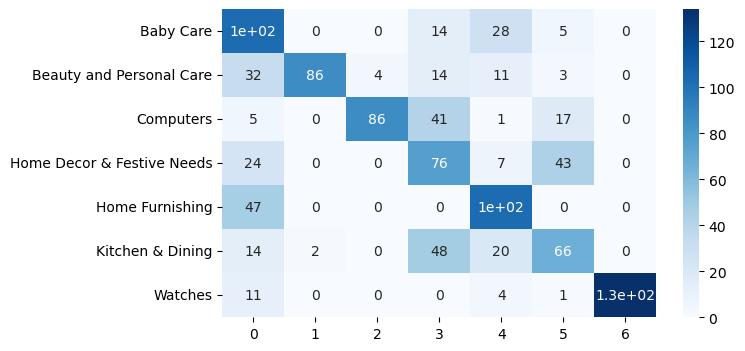

In [27]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

On constate qu'il existe des erreurs pour certains clusters mais d'autres semblent assez bien correspondre aux catégories, comme c'est le cas pour le cluster 1 qui semble correspondre à *Beauty and Personal Care*, le cluster 2 à *Computers* et le cluster 6 à *Watches*.

## <a id="3"></a> 1.2 BERT HuggingFace

BERT (Bidirectional Encoder Representations from Transformers) est un modèle de traitement du langage naturel (NLP) basé sur l'apprentissage profond. Il s'agit d'un modèle de représentation de langage pré-entraîné sur de vastes quantités de données textuelles non annotées.

BERT utilise un réseau de neurones à transformateurs (transformer neural network) bidirectionnel pour capturer les relations entre les mots dans une phrase.

Le modèle BERT a été pré-entraîné sur des gigaoctets de données textuelles provenant de sources diverses telles que Wikipédia et Common Crawl. Il peut ensuite être finement ajusté sur des tâches spécifiques telles que la classification de texte, l'analyse de sentiments, la traduction automatique, etc.

Le modèle BERT Hugging Face est une implémentation de BERT pré-entraîné qui peut être utilisé pour des tâches  de NLP. 

'bert-base-uncased' est l'un des modèles BERT pré-entraînés. Il s'agit d'une version de base du modèle BERT qui a été entraîné sur un corpus de texte de grande taille et qui peut être utilisé pour des tâches spécifiques de NLP telles que la classification de texte, l'analyse de sentiments, la traduction automatique, etc.

In [28]:
def bert_inp_fct(descriptions, bert_tokenizer) :
    '''Fonction de préparation des descriptions.'''
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for desc in descriptions:
        bert_inp = bert_tokenizer.encode_plus(desc,
                                              add_special_tokens = True,
                                              #max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

def feature_BERT_fct(model, model_type, descriptions, batch_size, mode='HF'):
    '''Fonction de création des features.'''
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(descriptions)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(descriptions[idx:idx+batch_size], 
                                                                               bert_tokenizer)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [29]:
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
descriptions = df_cat['descr_dl'].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [32]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, descriptions, 
                                                        batch_size, mode='HF')

1/1 [==============================] - 1s 676ms/step
temps traitement :  199.0


In [33]:
pickle.dump(features_bert, open('models/list_features_BERT1.pkl', 'wb'))

In [35]:
ARI_hf, X_tsne_hf, labels_hf = fc.ARI_fct_tsne(features_bert, liste_cat, df_cat["label"])

ARI :  0.3068 time :  5.0


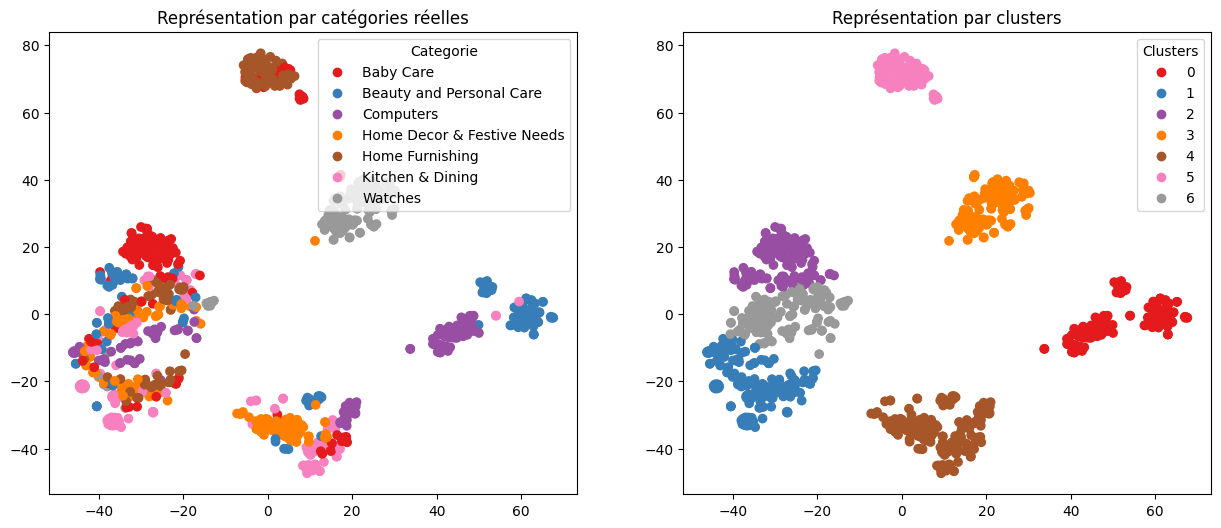

ARI :  0.3068


In [33]:
fc.TSNE_visu_fct(X_tsne_hf, liste_cat, df_cat["label"], labels_hf, ARI_hf)

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. En effet, on constate que la plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme *Watches*, *Home Furnishing*, *Beauty and Personal Care* ou encore *Computers*.

Ici nous obtenons un ARI légèrement inférieur à celui de Word2Vec à 0.3068.

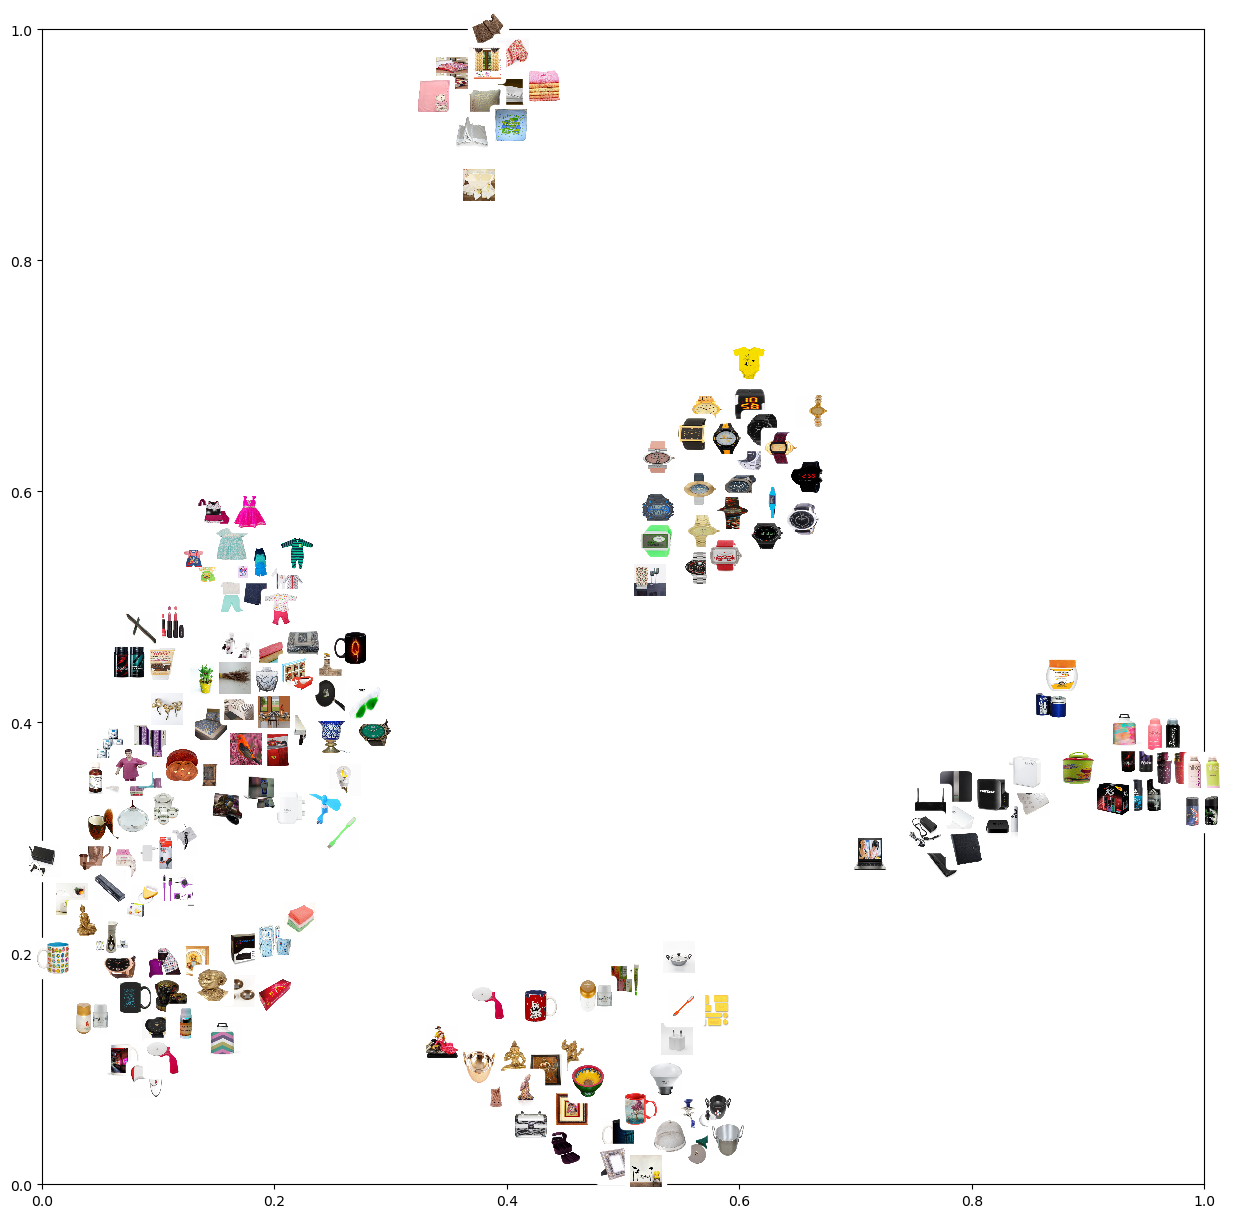

In [96]:
fc.plot_TSNE_images(X_tsne_hf, df_cat, path_images)

On affiche une partie des images sur la visualisation 2D avec les données TSNE calculées précédemment. On constate que certaines catégories sont bien regroupées et séparées à certains endroits. Par exemple, on retouve des montres au centre, des produits de beauté à droite, du matériel électronique à droite, ou encore des fournitures de maison en haut. Au centre, les catégories sont mélangées.

Visualisons désormais la réduction de dimension via une ACP.

In [36]:
pca = PCA()
pca.fit(features_bert)

PCA()

In [37]:
pca.explained_variance_ratio_.cumsum()

array([0.3571975 , 0.48737094, 0.5411808 , 0.58269215, 0.62098145,
       0.6507932 , 0.66983837, 0.68773013, 0.7020684 , 0.71466094,
       0.72579014, 0.73648983, 0.746221  , 0.7548702 , 0.76318896,
       0.7707787 , 0.7779671 , 0.7845741 , 0.791162  , 0.7970793 ,
       0.80245876, 0.80745476, 0.8121585 , 0.816764  , 0.8212234 ,
       0.8254547 , 0.82943356, 0.83328944, 0.8370317 , 0.8407127 ,
       0.8442093 , 0.84747016, 0.8506072 , 0.853631  , 0.8566212 ,
       0.85945666, 0.8622433 , 0.8648955 , 0.86748534, 0.8700127 ,
       0.87247336, 0.8748068 , 0.87711334, 0.87933356, 0.881465  ,
       0.8835544 , 0.8855873 , 0.8875587 , 0.8894285 , 0.8912718 ,
       0.8930499 , 0.89480346, 0.8965093 , 0.8982082 , 0.8998307 ,
       0.9014286 , 0.9029892 , 0.9045239 , 0.90602493, 0.90747833,
       0.90891653, 0.9103065 , 0.91168654, 0.9130402 , 0.9143749 ,
       0.91567504, 0.9169385 , 0.91818804, 0.9194095 , 0.9206273 ,
       0.9218202 , 0.92298406, 0.92412335, 0.92522156, 0.92629

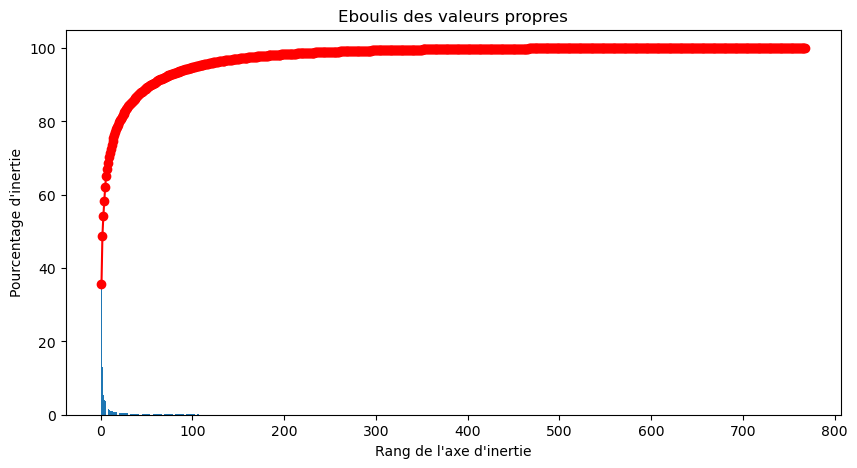

In [39]:
fc.eboulis(pca)

Les deux premières composantes de la PCA n'expliquent que 49% de la variance expliquée. Nous perdrions beaucoup d'information si nous décidions de n'utiliser que ces 2 premières composantes.

Nous allons donc réaliser une ACP afin de réduire nos dimensions puis ensuite réaliser un TSNE sur cette réduction.

**Réduction de dimension ACP :**

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%). L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [40]:
print("Dimensions dataset avant réduction PCA : ", features_bert.shape)
pca = PCA(n_components=0.99)
feat_pca_hf = pca.fit_transform(features_bert)
print("Dimensions dataset après réduction PCA : ", feat_pca_hf.shape)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 254)


In [38]:
ARI_hf, X_tsne_hf, labels_hf = fc.ARI_fct_tsne(feat_pca_hf, liste_cat, df_cat["label"])

ARI :  0.3057 time :  25.0


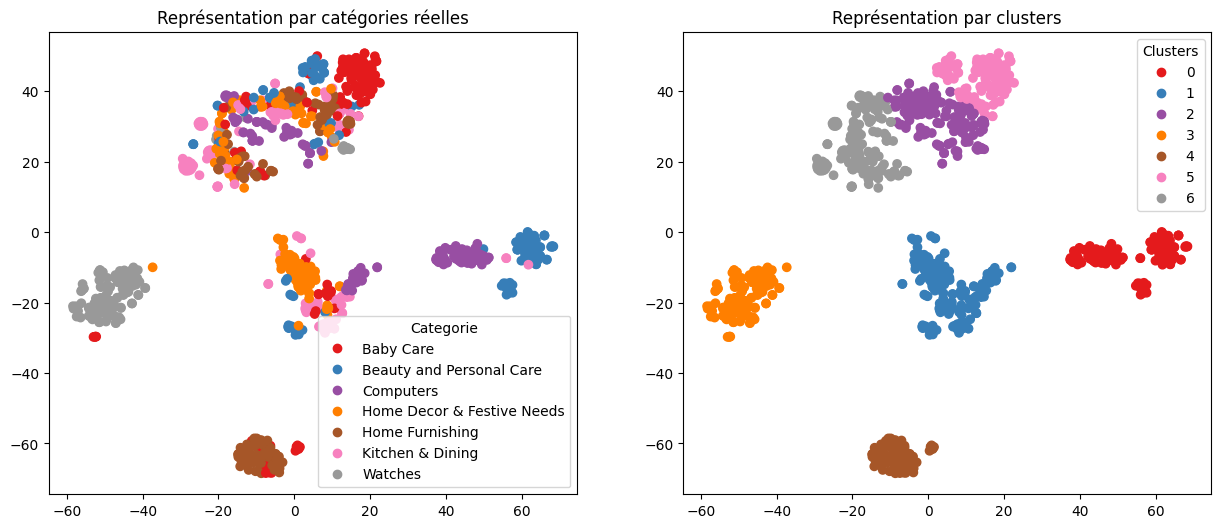

ARI :  0.3057


In [39]:
fc.TSNE_visu_fct(X_tsne_hf, liste_cat, df_cat["label"], labels_hf, ARI_hf)

On obtient une très légère dégradation de l'ARI (0.3057) après avoir effectué une réduction de dimension via ACP puis une projection TSNE à 2 composantes.

On constate cependant toujours que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. La plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés comme ceux cités précédemment.

**Analyse par classes**

In [41]:
conf_mat = metrics.confusion_matrix(df_cat["label"], labels_hf)
conf_mat

array([[ 15,   0,  20,  90,  14,   5,   6],
       [ 10,  80,   0,  24,  21,   0,  15],
       [ 27,  70,   0,   0,  24,   0,  29],
       [ 33,   0,   0,   3,  81,   1,  32],
       [ 27,   0,  74,   7,   0,   0,  42],
       [ 62,   3,   0,  11,  52,   0,  22],
       [  5,   0,   0,   0,   0, 135,  10]])

In [44]:
corresp = [5,1,4,0,3,6,2]
cls_labels_transform = fc.conf_mat_transform(df_cat["label"], labels_hf, corresp)
conf_mat = metrics.confusion_matrix(df_cat["label"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(df_cat["label"], cls_labels_transform))

Correspondance des clusters :  [5, 1, 4, 0, 3, 6, 2]
[[ 90   0   6  14  20  15   5]
 [ 24  80  15  21   0  10   0]
 [  0  70  29  24   0  27   0]
 [  3   0  32  81   0  33   1]
 [  7   0  42   0  74  27   0]
 [ 11   3  22  52   0  62   0]
 [  0   0  10   0   0   5 135]]

              precision    recall  f1-score   support

           0       0.67      0.60      0.63       150
           1       0.52      0.53      0.53       150
           2       0.19      0.19      0.19       150
           3       0.42      0.54      0.47       150
           4       0.79      0.49      0.61       150
           5       0.35      0.41      0.38       150
           6       0.96      0.90      0.93       150

    accuracy                           0.52      1050
   macro avg       0.56      0.52      0.53      1050
weighted avg       0.56      0.52      0.53      1050



<Axes: >

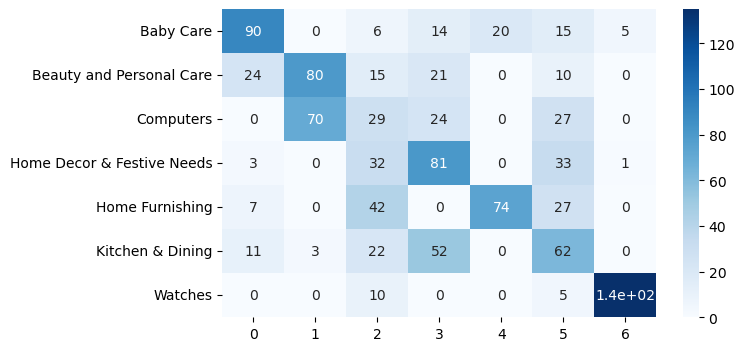

In [45]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

On constate qu'il existe des erreurs pour certains clusters mais d'autres semblent assez bien correspondre aux catégories, comme c'est le cas pour le cluster 6 qui semble correspondre à *Watches*. Certains cluster semblent présenter une hésitation entre 2 catégories: le cluster 4 semble correspondre à *Home Furnishing* mais présente des erreurs dans la catgorie *Baby Care* ou encore le cluster 1 semble correspondre à *Beauty and Personnal Care* mais présente beaucoup d'erreur dans la catégorie *Computers*.


## <a id="4"></a> 1.3 BERT Tensorflow Hub

Le modèle BERT TensorFlow Hub est un modèle de traitement du langage naturel basé sur BERT et développé par Google. TensorFlow Hub est une bibliothèque open source de modèles de machine learning pré-entraînés développée par Google et fournit une interface simple pour utiliser des modèles pré-entraînés pour des tâches de machine learning.

In [46]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)
descriptions = df_cat['descr_dl'].to_list()

In [47]:
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert_tfh, last_hidden_states_tot_tfh = feature_BERT_fct(model, model_type, descriptions, 
                                                                 batch_size, mode='TFhub')

temps traitement :  951.0


In [48]:
pickle.dump(features_bert_tfh, open('models/list_features_BERT2.pkl', 'wb'))

In [63]:
features_bert_tf = pickle.load(open('models/list_features_BERT2.pkl', 'rb'))

In [68]:
ARI_tfh, X_tsne_tfh, labels_tfh = fc.ARI_fct_tsne(features_bert_tfh, liste_cat, df_cat["label"])

ARI :  0.3073 time :  5.0


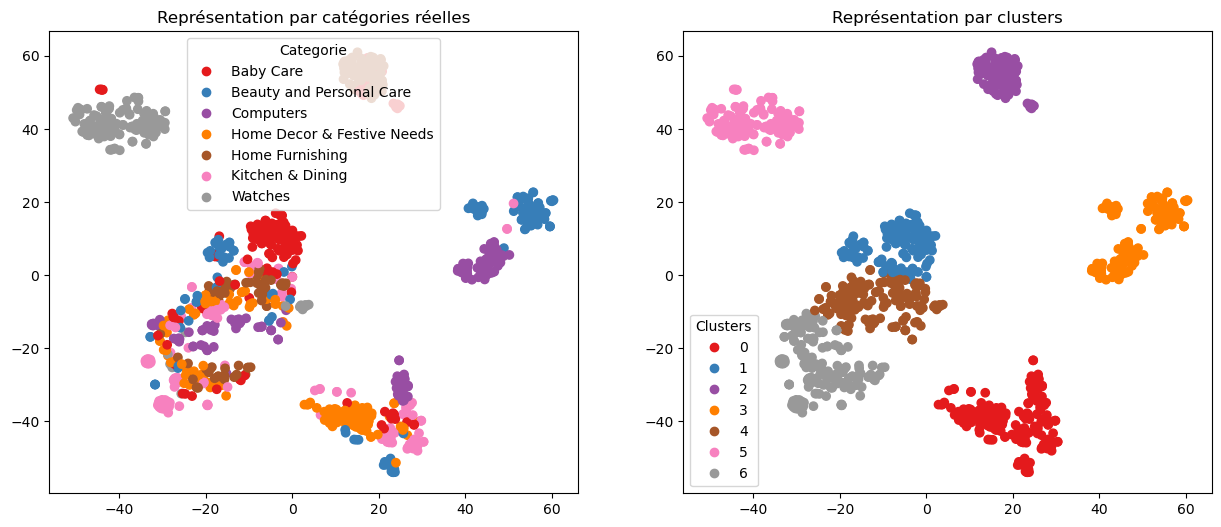

ARI :  0.3073


In [50]:
fc.TSNE_visu_fct(X_tsne_tfh, liste_cat, df_cat["label"], labels_tfh, ARI_tfh)

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. En effet, on constate que la plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme *Watches*, *Home Furnishing*, *Beauty and Personal Care* ou encore *Computers*.

Ici nous obtenons un ARI à 0.3073.

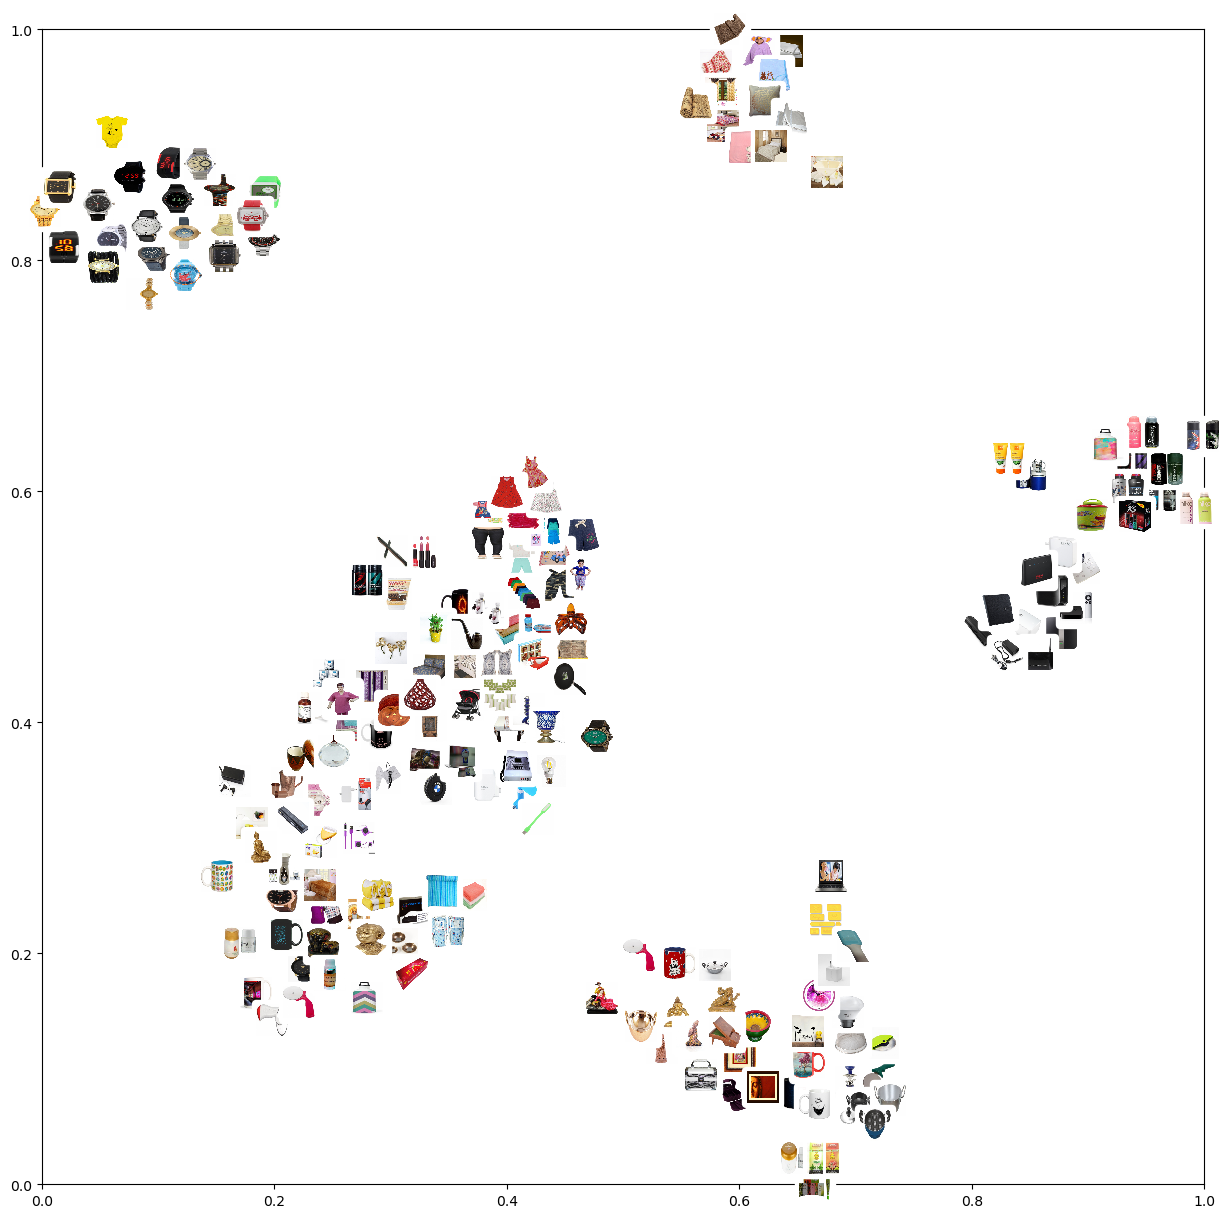

In [97]:
fc.plot_TSNE_images(X_tsne_tfh, df_cat, path_images)

On affiche une partie des images sur la visualisation 2D avec les données TSNE calculées précédemment. On constate que certaines catégories sont bien regroupées et séparées à certains endroits. Par exemple, on retrouve des montres en haut à gauche, des produits de beauté à droite ainsi que du matériel électronique, ou encore des fournitures de maison en haut. Elles sont bien séparées et espacées. Au centre, les catégories sont mélangées.

Visualisons désormais la réduction de dimension via une ACP.

In [51]:
pca = PCA()
pca.fit(features_bert_tfh)

PCA()

In [52]:
pca.explained_variance_ratio_.cumsum()

array([0.35706505, 0.48730922, 0.5410935 , 0.58259225, 0.62087536,
       0.65067565, 0.6697096 , 0.6876012 , 0.70192266, 0.7145127 ,
       0.7256585 , 0.7363609 , 0.7460846 , 0.7547382 , 0.76305586,
       0.77063817, 0.7778248 , 0.7844294 , 0.79101604, 0.79693115,
       0.8023102 , 0.8073021 , 0.81200415, 0.8166103 , 0.8210704 ,
       0.82530576, 0.829284  , 0.8331407 , 0.8368807 , 0.84055865,
       0.84405726, 0.84731716, 0.85045683, 0.8534843 , 0.8564777 ,
       0.85931516, 0.8621007 , 0.86475337, 0.86734426, 0.8698708 ,
       0.87233216, 0.874667  , 0.876975  , 0.8791949 , 0.8813266 ,
       0.8834168 , 0.8854491 , 0.887423  , 0.8892939 , 0.8911372 ,
       0.8929152 , 0.8946692 , 0.89637643, 0.8980763 , 0.8996996 ,
       0.90129745, 0.90285945, 0.90439487, 0.90589654, 0.90735036,
       0.9087903 , 0.9101819 , 0.9115637 , 0.9129186 , 0.91425407,
       0.91555566, 0.9168202 , 0.91807   , 0.91929257, 0.92051154,
       0.92170507, 0.9228696 , 0.924009  , 0.92510813, 0.92618

In [59]:
fc.eboulis(pca)

Les deux premières composantes de la PCA n'expliquent que 49% de la variance expliquée. Nous perdrions beaucoup d'information si nous décidions de n'utiliser que ces 2 premières composantes.

Nous allons donc réaliser une ACP afin de réduire nos dimensions puis ensuite réaliser un TSNE sur cette réduction.

**Réduction de dimension ACP :**

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%). L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [65]:
print("Dimensions dataset avant réduction PCA : ", features_bert_tfh.shape)
pca = PCA(n_components=0.99)
feat_pca_tfh = pca.fit_transform(features_bert_tfh)
print("Dimensions dataset après réduction PCA : ", feat_pca_tfh.shape)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 255)


In [66]:
ARI_tfh, X_tsne_tfh, labels_tfh = fc.ARI_fct_tsne(feat_pca_tfh, liste_cat, df_cat["label"])

ARI :  0.3055 time :  5.0


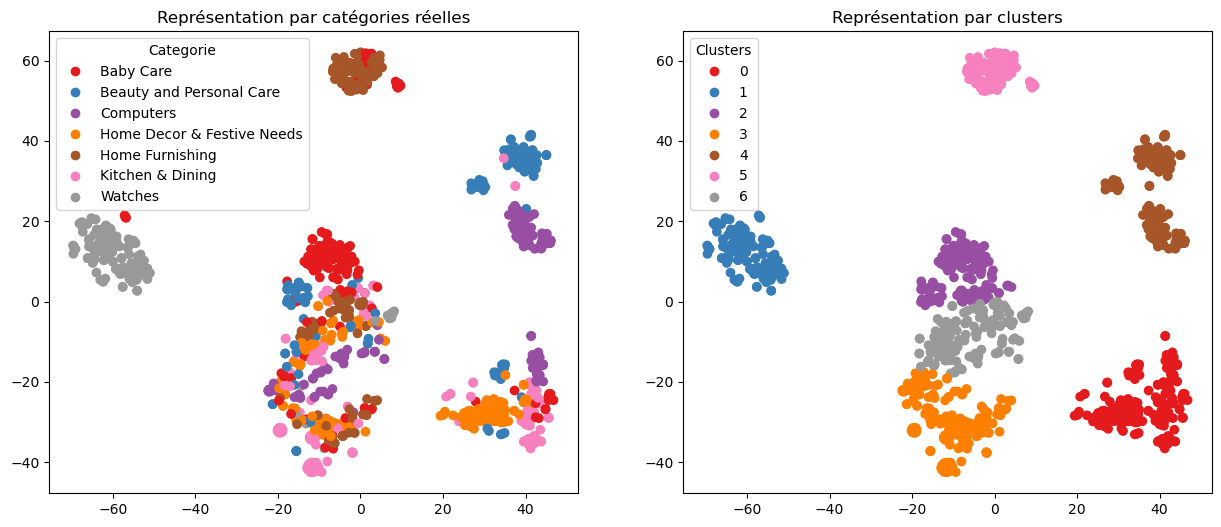

ARI :  0.3055


In [67]:
fc.TSNE_visu_fct(X_tsne_tfh, liste_cat, df_cat["label"], labels_tfh, ARI_tfh)

On obtient une très légère dégradation de l'ARI (0.3055) après avoir effectué une réduction de dimension via ACP puis une projection TSNE à 2 composantes.

On constate cependant toujours que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. La plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés comme ceux cités précédemment.

**Analyse par classes**

In [69]:
conf_mat = metrics.confusion_matrix(df_cat["label"], labels_tfh)
conf_mat

array([[ 14,  90,  20,   0,   6,   5,  15],
       [ 21,  24,   0,  80,  15,   0,  10],
       [ 26,   0,   0,  68,  29,   0,  27],
       [ 81,   1,   0,   0,  35,   0,  33],
       [  0,   5,  74,   0,  44,   0,  27],
       [ 52,  10,   0,   3,  23,   0,  62],
       [  0,   0,   0,   0,  10, 135,   5]])

In [71]:
corresp = [3,0,4,1,2,6,5]
cls_labels_transform = fc.conf_mat_transform(df_cat["label"], labels_tfh, corresp)
conf_mat = metrics.confusion_matrix(df_cat["label"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(df_cat["label"], cls_labels_transform))

Correspondance des clusters :  [3, 0, 4, 1, 2, 6, 5]
[[ 90   0   6  14  20  15   5]
 [ 24  80  15  21   0  10   0]
 [  0  68  29  26   0  27   0]
 [  1   0  35  81   0  33   0]
 [  5   0  44   0  74  27   0]
 [ 10   3  23  52   0  62   0]
 [  0   0  10   0   0   5 135]]

              precision    recall  f1-score   support

           0       0.69      0.60      0.64       150
           1       0.53      0.53      0.53       150
           2       0.18      0.19      0.19       150
           3       0.42      0.54      0.47       150
           4       0.79      0.49      0.61       150
           5       0.35      0.41      0.38       150
           6       0.96      0.90      0.93       150

    accuracy                           0.52      1050
   macro avg       0.56      0.52      0.54      1050
weighted avg       0.56      0.52      0.54      1050



<Axes: >

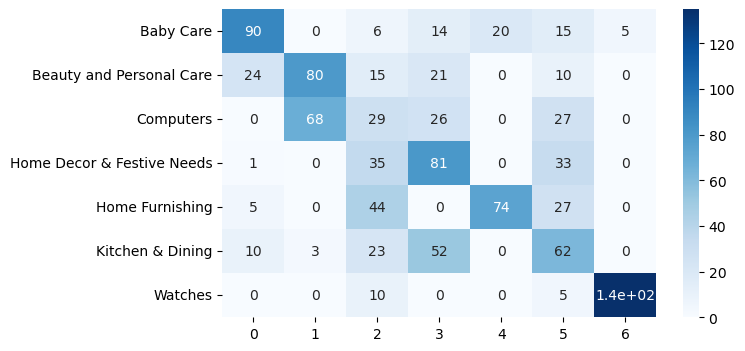

In [72]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_cat],
                     columns = [i for i in "0123456"])
plt.figure(figsize = (7,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

On constate qu'il existe des erreurs pour certains clusters mais d'autres semblent assez bien correspondre aux catégories, comme c'est le cas pour le cluster 6 qui semble correspondre à *Watches*. Certains cluster semblent présenter une hésitation entre 2 catégories: le cluster 4 semble correspondre à *Home Furnishing* mais présente des erreurs dans la catgorie *Baby Care* ou encore le cluster 1 semble correspondre à *Beauty and Personnal Care* mais présente beaucoup d'erreur dans la catégorie *Computers*.


## <a id="5"></a> 1.4 USE : Universal Sentence Encoder

USE (Universal Sentence Encoder) est un modèle de traitement du langage naturel développé par Google. Il permet de convertir des phrases en vecteurs de nombre réels, également appelés embeddings, qui capturent le sens sémantique de la phrase. Le modèle est entraîné sur un grand corpus de texte en plusieurs langues et est capable de comprendre les nuances sémantiques et contextuelles des phrases dans différentes langues.

In [73]:
def feature_USE_fct(descriptions, batch_size):
    time1 = time.time()

    for step in range(len(descriptions)//batch_size) :
        idx = step*batch_size
        feat = embed(descriptions[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [74]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
descriptions = df_cat['descr_dl'].to_list()
batch_size = 10

In [75]:
features_USE = feature_USE_fct(descriptions, batch_size)

In [76]:
pickle.dump(features_USE, open('models/list_features_USE.pkl', 'wb'))

In [77]:
ARI_use, X_tsne_use, labels_use = fc.ARI_fct_tsne(features_USE, liste_cat, df_cat["label"])

ARI :  0.4342 time :  5.0


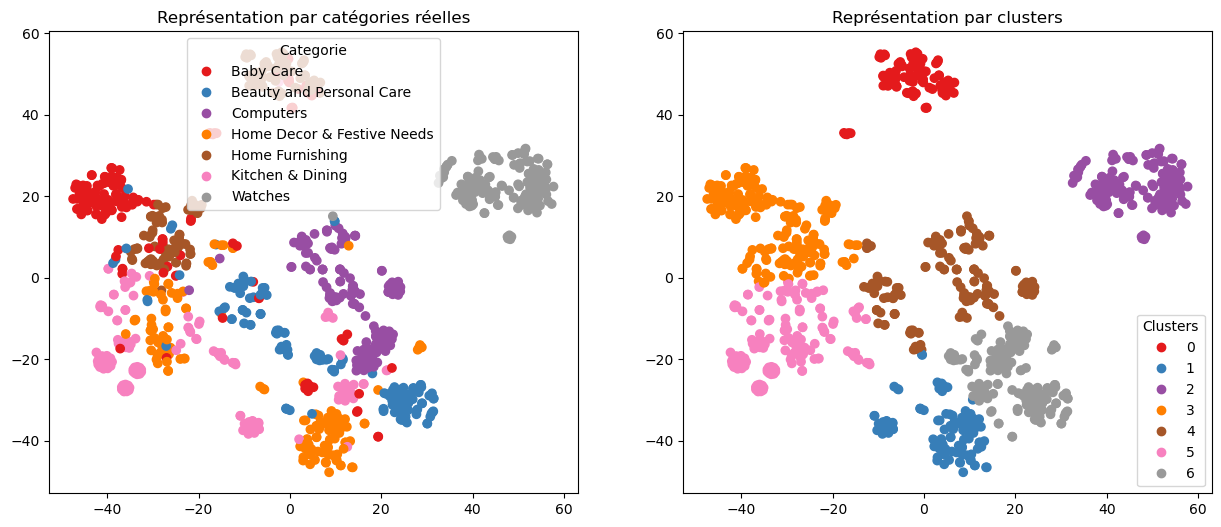

ARI :  0.4342


In [78]:
fc.TSNE_visu_fct(X_tsne_use, liste_cat, df_cat["label"], labels_use, ARI_use)

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. En effet, on constate que la plupart des catégories se mélangent plus dans la représentation réelle. Cependant, on constate tout de même que le modèle a réussi à capturer une certaine complexité malgré tout. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme *Watches* ou encore *Home Furnishing*.

Ici nous obtenons l'ARI le plus élevé des différents modèles de traitement de texte, à 0.4342.

Visualisons désormais la réduction de dimension via une ACP.

In [79]:
pca = PCA()
pca.fit(features_USE)

PCA()

In [80]:
pca.explained_variance_ratio_.cumsum()

array([0.16806972, 0.22747318, 0.27945668, 0.32322735, 0.3492256 ,
       0.3724151 , 0.39390248, 0.41337144, 0.4312539 , 0.4483512 ,
       0.4625301 , 0.47653997, 0.48999992, 0.50274694, 0.5147634 ,
       0.52547824, 0.53608304, 0.5462381 , 0.5558888 , 0.5649895 ,
       0.5739139 , 0.5825367 , 0.5905372 , 0.5982149 , 0.6056055 ,
       0.61263746, 0.6195674 , 0.6263262 , 0.63295674, 0.63937527,
       0.64567226, 0.6517864 , 0.6576754 , 0.66335887, 0.66892266,
       0.67438024, 0.679635  , 0.6848013 , 0.6899322 , 0.69493186,
       0.69987357, 0.7046204 , 0.7093012 , 0.71393883, 0.7184835 ,
       0.7229623 , 0.7273671 , 0.73158514, 0.7356696 , 0.73971605,
       0.74365723, 0.74753666, 0.7513655 , 0.75508684, 0.75870526,
       0.76224905, 0.7657028 , 0.7691341 , 0.7724471 , 0.7757191 ,
       0.77895904, 0.78216106, 0.7853287 , 0.7884152 , 0.79143107,
       0.7944114 , 0.79734826, 0.80024666, 0.80310607, 0.8059503 ,
       0.8086728 , 0.81137604, 0.8140646 , 0.81672144, 0.81931

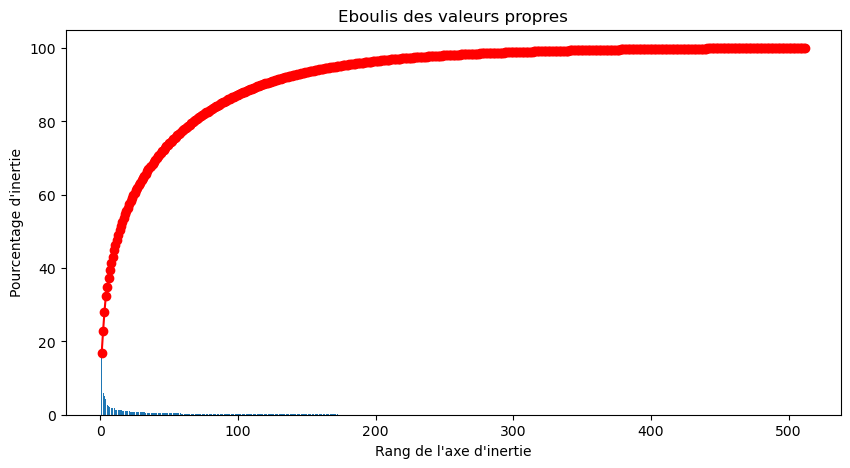

In [81]:
fc.eboulis(pca)

Les deux premières composantes de la PCA n'expliquent que 23% de la variance expliquée. Nous perdrions beaucoup d'information si nous décidions de n'utiliser que ces 2 premières composantes.

Nous allons donc réaliser une ACP afin de réduire nos dimensions puis ensuite réaliser un TSNE sur cette réduction.

**Réduction de dimension ACP :**

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%). L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [82]:
print("Dimensions dataset avant réduction PCA : ", features_USE.shape)
pca = PCA(n_components=0.99)
feat_pca_use = pca.fit_transform(features_USE)
print("Dimensions dataset après réduction PCA : ", feat_pca_use.shape)

Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 310)


In [83]:
ARI_use2, X_tsne_use2, labels_use2 = fc.ARI_fct_tsne(feat_pca_use, liste_cat, df_cat["label"])

ARI :  0.4365 time :  5.0


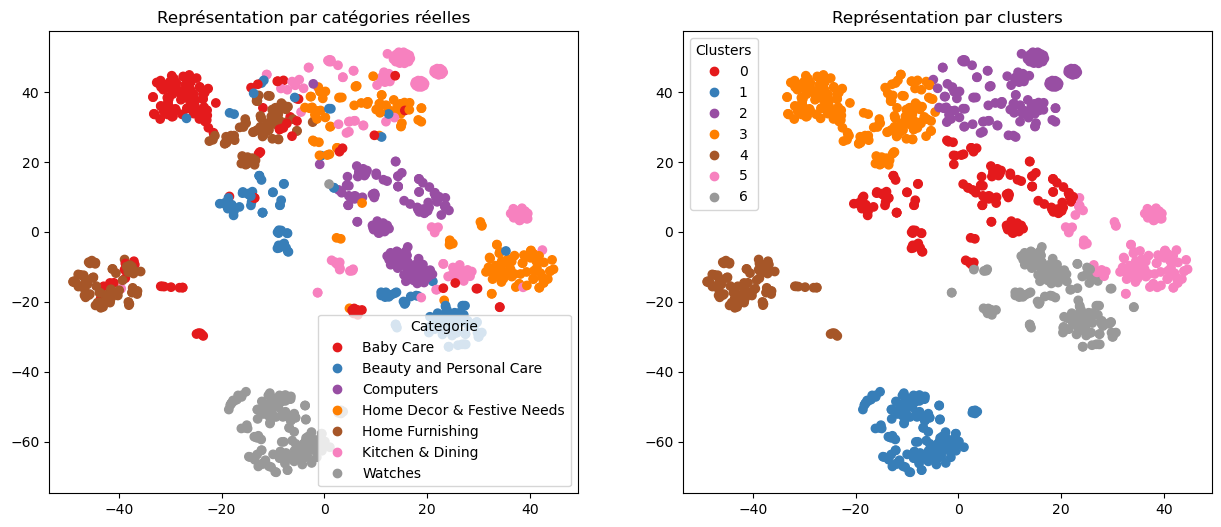

ARI :  0.4365


In [84]:
fc.TSNE_visu_fct(X_tsne_use2, liste_cat, df_cat["label"], labels_use2, ARI_use2)

On obtient une légère amélioration de l'ARI (0.4365) après avoir effectué une réduction de dimension via ACP puis une projection TSNE à 2 composantes.

On constate cependant toujours que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. La plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, comme ceux cités précédemment.

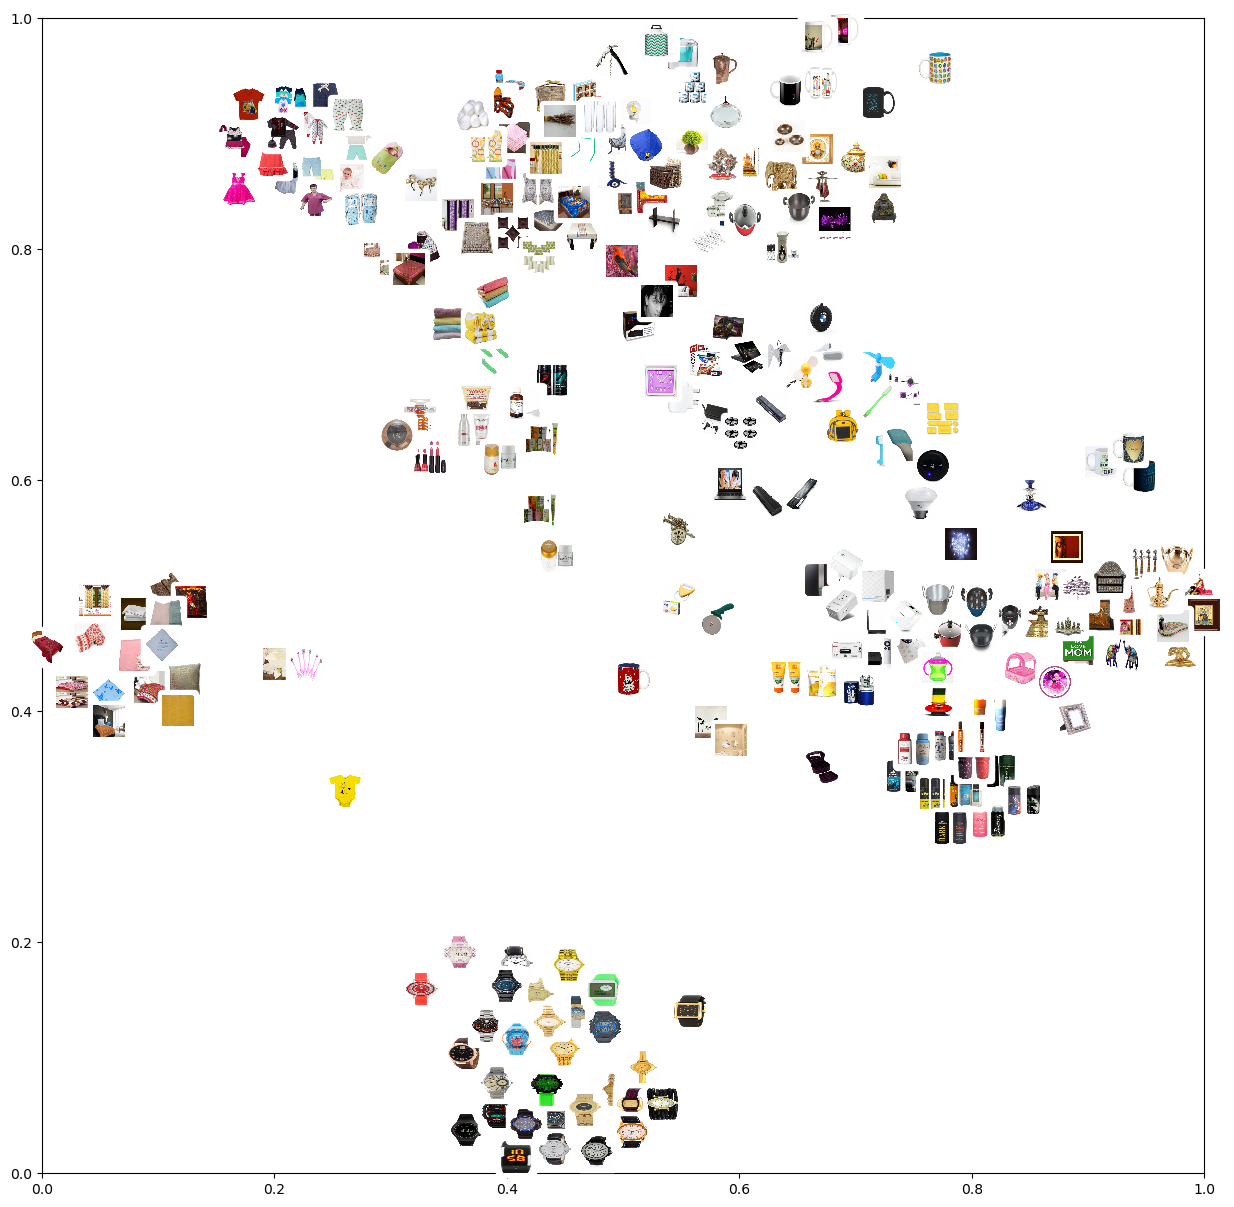

In [98]:
fc.plot_TSNE_images(X_tsne_use2, df_cat, path_images)

On affiche une partie des images sur la visualisation 2D avec les données TSNE calculées précédemment. On constate que certaines catégories sont bien regroupées et séparées à certains endroits. Par exemple, on retouve des montres en bas, des produits de beauté à droite ainsi que du matériel électronique et des fournitures de maison, ou encore des produits pour bébés en haut à gauche. Au centre, les catégories sont mélangées.

**Analyse par classes**

In [86]:
conf_mat = metrics.confusion_matrix(df_cat["label"], labels_use2)
conf_mat

array([[  5,   0,   3, 103,  25,   0,  14],
       [ 54,   0,   4,   7,   0,   1,  84],
       [ 92,   0,   1,   0,   0,   6,  51],
       [ 13,   0,  58,   0,   0,  77,   2],
       [  0,   0,   1,  75,  74,   0,   0],
       [  5,   0,  83,   8,   1,  31,  22],
       [  1, 149,   0,   0,   0,   0,   0]])

In [89]:
corresp = 'argmax'
cls_labels_transform = fc.conf_mat_transform(df_cat["label"], labels_use2, corresp)
conf_mat = metrics.confusion_matrix(df_cat["label"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(df_cat["label"], cls_labels_transform))

Correspondance des clusters :  [2 6 5 0 4 3 1]
[[103  14   5   0  25   3   0]
 [  7  84  54   1   0   4   0]
 [  0  51  92   6   0   1   0]
 [  0   2  13  77   0  58   0]
 [ 75   0   0   0  74   1   0]
 [  8  22   5  31   1  83   0]
 [  0   0   1   0   0   0 149]]

              precision    recall  f1-score   support

           0       0.53      0.69      0.60       150
           1       0.49      0.56      0.52       150
           2       0.54      0.61      0.57       150
           3       0.67      0.51      0.58       150
           4       0.74      0.49      0.59       150
           5       0.55      0.55      0.55       150
           6       1.00      0.99      1.00       150

    accuracy                           0.63      1050
   macro avg       0.65      0.63      0.63      1050
weighted avg       0.65      0.63      0.63      1050



<Axes: >

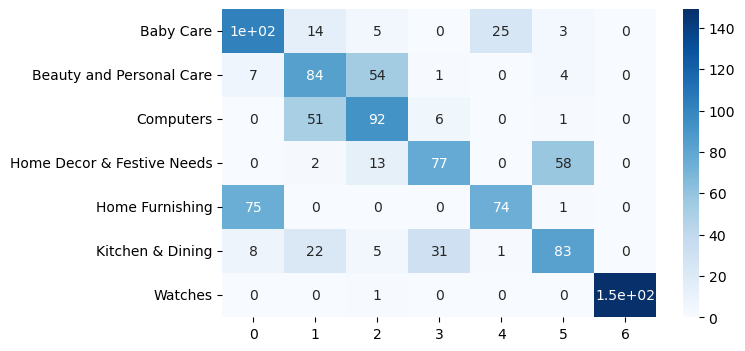

In [90]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

On constate qu'il existe des erreurs pour certains clusters mais d'autres semblent assez bien correspondre aux catégories, comme c'est le cas pour le cluster 6 qui semble correspondre à Watches, avec aucune erreur dans les autres catégories. 
Certains clusters semblent présenter une hésitation entre 2 catégories: le cluster 1 semble correspondre à *Baby Care* mais présente des erreurs dans la catégorie *Home Furnishing* (l'inverse est également visible sur le cluster 4) ou encore les cluster 3 et 5 qui réalisent des erreurs dans *Kitchen & Dining* et *Home Decor & Festive Needs*.

Par rapport aux autres modèles, les clusters semblent contenir des erreurs dans moins de catégories. En effet, la plupart se trouvent dans 2 voire 3 catégories.


# <a id="6"></a> 2. Traitement des données visuelles

Nous allons désormais extraire des features de nos données visuelles via un algorithme de Transfer Learning basé sur des réseaux de neurones tel que CNN.

CNN signifie "Convolutional Neural Network" (Réseau de neurones convolutifs). C'est un type de réseau de neurones artificiels très utilisé pour le traitement d'images. Ils sont conçus pour détecter des motifs dans des images en utilisant des filtres appelés "convolutions". Ces filtres sont appliqués à l'image d'entrée pour extraire des caractéristiques spécifiques telles que des bords, des coins, des textures, des formes, etc.

Notre choix s'oriente sur un modèle VGG16. C'est un réseau de neurones convolutifs profond (CNN). Il a une architecture composée de 13 couches de convolution et de 3 couches entièrement connectées. Les 13 couches de convolution sont des blocs de convolution simples, chacun composé de deux ou trois couches de convolution avec des filtres de petite taille (3x3) et une couche de max pooling pour réduire la dimensionnalité de l'image. Les trois couches entièrement connectées sont utilisées pour la classification finale. 
Il prend en entrée une image en couleurs de taille 224x224  et la classifie dans une des 1000 classes.

Ici, nous souhaitons utiliser ce modèle pré-entraîné non pas pour classifier nos images dans une des 1000 classes mais pour extraire des features. Pour cela, on supprime les dernières couches en ajoutant **outputs=base_model.layers[-2].output**. Ainsi, nous ne récuperons que les features.

In [23]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
path_images = "Flipkart/Images/"
list_photos = [file for file in listdir(path_images)]

In [25]:
len(list_photos)

1050

In [26]:
len(df_cat['image'])

1050

Nous devons d'abord charger l'image et la pré-traiter afin qu'elle respecte bien les spécifications des images en entrée de VGG-16: 
- VGG-16 reçoit des images de taille (224, 224, 3) : la fonction **load_img** permet de charger l'image et de la redimensionner correctement.
- Keras traite les images comme des tableaux numpy : **img_to_array** permet de convertir l'image chargée en tableau numpy.
- Le réseau doit recevoir en entrée une collection d'images, stockée dans un tableau de 4 dimensions, où les dimensions correspondent (dans l'ordre) à (nombre d'images, largeur, hauteur, profondeur). Pour l'instant, nous donnons qu'une image en entrée : **numpy.reshape** permet d'ajouter la première dimension (nombre d'images = 1) à notre image.
- Enfin, **preprocess_input** permet d'appliquer les mêmes pré-traitements que ceux utilisés sur l'ensemble d'apprentissage lors du pré-entraînement.

In [27]:
def extract_features_img(df, path, model):

    images_features = []

    for image_num in range(len(df['image'])) :
        image = load_img(path + df['image'][image_num], target_size=(224, 224))
        image = img_to_array(image) 
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        images_features.append(model.predict(image, verbose = 0)[0]) # predict from pretrained model

    images_features = np.asarray(images_features)
    print(images_features.shape)
    return images_features


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 4096)

In [ ]:
images_features = extract_features_img(df_cat, path_images, model)

In [28]:
pickle.dump(images_features, open('models/list_features_VGG16.pkl', 'wb'))

In [100]:
images_features = pickle.load(open('models/list_features_VGG16.pkl', 'rb'))

In [102]:
ARI_vgg, X_tsne_vgg, labels_vgg = fc.ARI_fct_tsne(images_features, liste_cat, df_cat["label"])

ARI :  0.465 time :  4.0


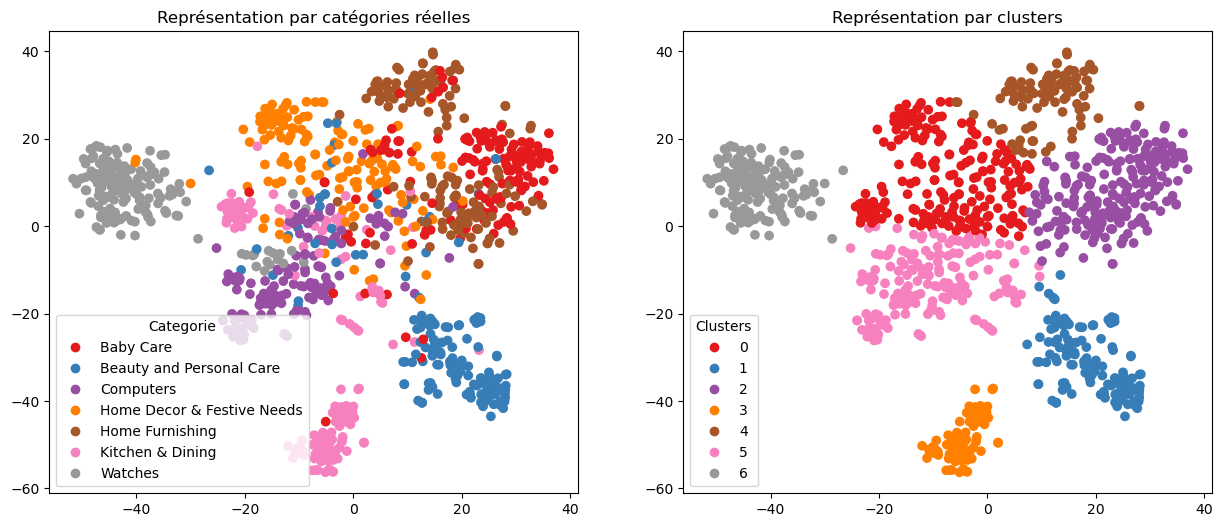

ARI :  0.465


In [67]:
fc.TSNE_visu_fct(X_tsne_vgg, liste_cat, df_cat["label"], labels_vgg, ARI_vgg)

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. En effet, on constate que la plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme *Watches*, *Kitchen & Dining* ou encore *Beauty and Personal Care*.

Ici nous obtenons un ARI, bien meilleur que pour la méthode SIFT, à 0.465.

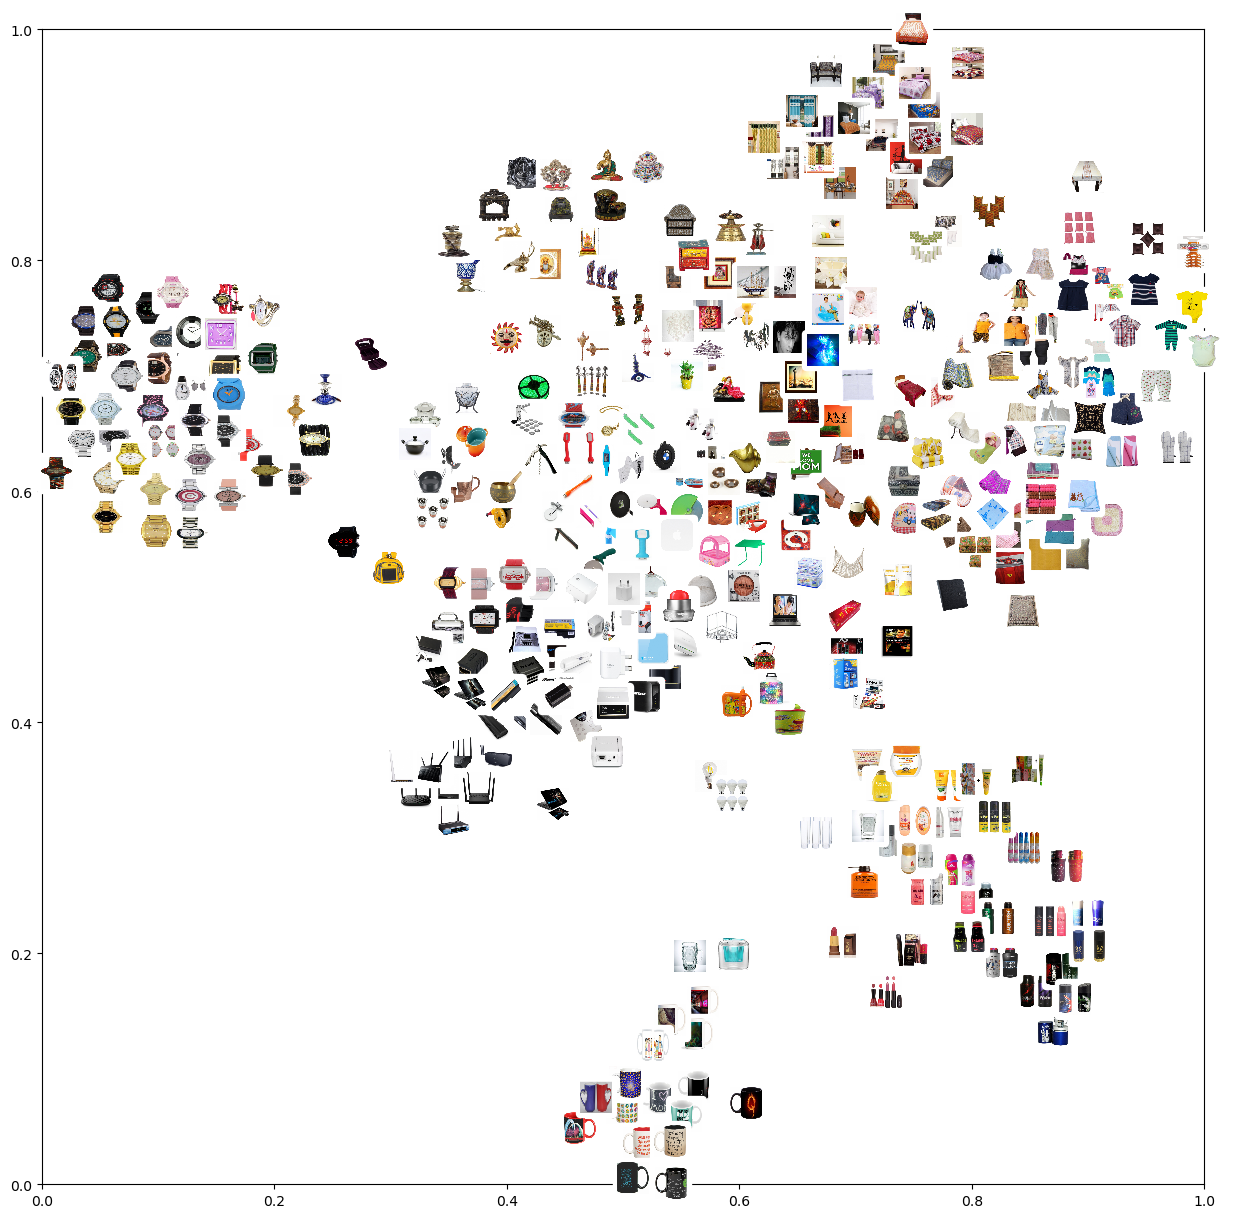

In [103]:
fc.plot_TSNE_images(X_tsne_vgg, df_cat, path_images)

On affiche une partie des images sur la visualisation 2D avec les données TSNE calculées précédemment. On constate que certaines catégories sont bien regroupées et séparées à certains endroits. Par exemple, on retouve des montres à gauche, des produits de beauté en bas à droite, du matériel électronique au centre, des fournitures de maison en haut ou encore des produits pour bébés en haut à droite. Au centre, les catégories sont mélangées, mais nous pouvons tout de même distinguer des regroupements.

Visualisons désormais la réduction de dimension via une ACP.

In [32]:
pca = PCA()
pca.fit(images_features)

PCA()

In [33]:
pca.explained_variance_ratio_.cumsum()

array([0.08030858, 0.14525406, 0.19508705, ..., 0.99999964, 0.99999964,
       0.99999964], dtype=float32)

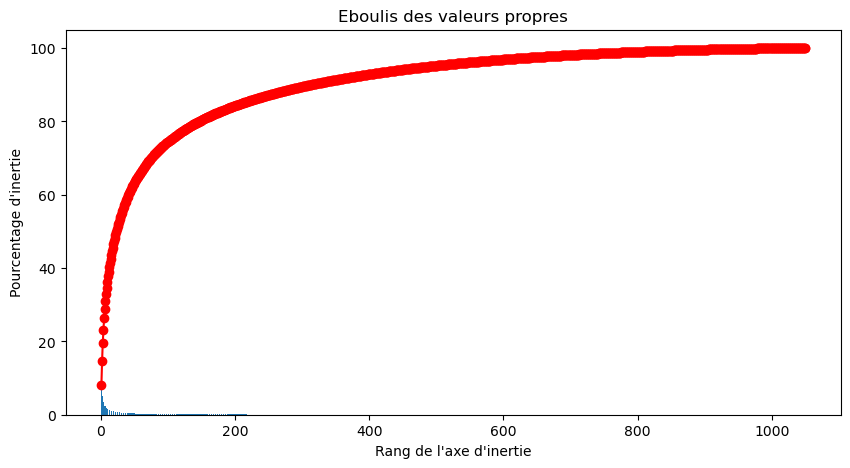

In [34]:
eboulis(pca)

Les deux premières composantes de la PCA n'expliquent que 14% de la variance expliquée. Nous perdrions beaucoup d'information si nous décidions de n'utiliser que ces 2 premières composantes.

Nous allons donc réaliser une ACP afin de réduire nos dimensions puis ensuite réaliser un TSNE sur cette réduction.

**Réduction de dimension ACP :**

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%). L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [118]:
print("Dimensions dataset avant réduction PCA : ", images_features.shape)
pca = PCA(n_components=0.99)
feat_pca_vgg = pca.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ", feat_pca_vgg.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


In [120]:
ARI_vgg2, X_tsne_vgg2, labels_vgg2 = fc.ARI_fct_tsne(feat_pca_vgg, liste_cat, df_cat["label"])

ARI :  0.4327 time :  4.0


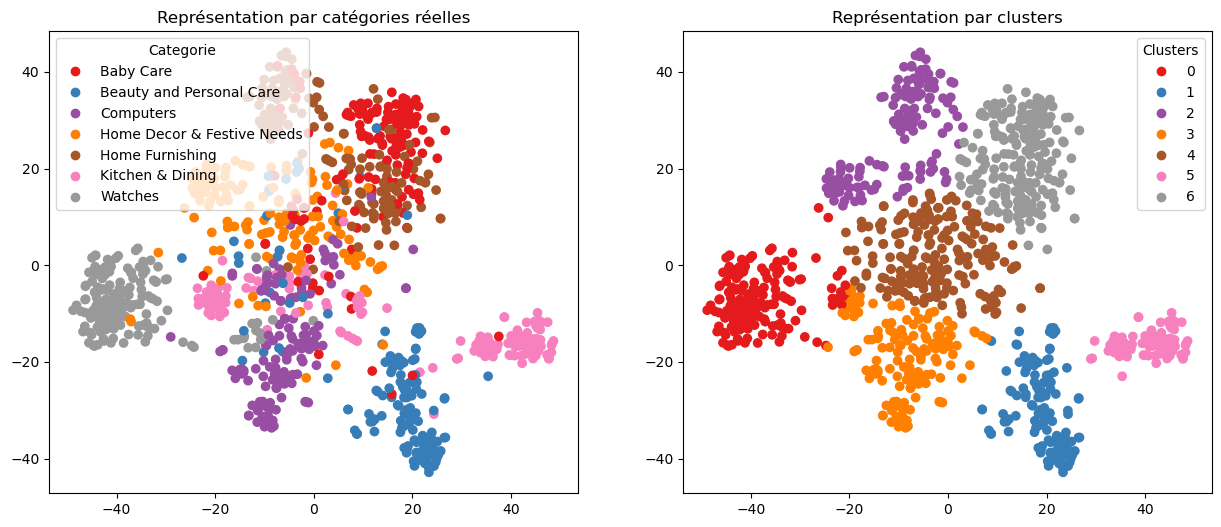

ARI :  0.4327


In [58]:
fc.TSNE_visu_fct(X_tsne_vgg2, liste_cat, df_cat["label"], labels_vgg2, ARI_vgg2)

On constate cependant toujours que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. La plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme celles citées précédemment.

Ici, l'ARI est de 0.4327.

**Analyse par classes**

In [39]:
conf_mat = metrics.confusion_matrix(df_cat["label"], labels_vgg)
conf_mat

array([[ 11,   3, 112,   1,  17,   6,   0],
       [ 12, 117,   7,   0,   1,  12,   1],
       [ 28,   2,   4,   0,   0, 116,   0],
       [110,   2,  16,   0,  11,   8,   3],
       [  3,   0,  75,   0,  71,   1,   0],
       [ 43,   3,   2,  78,   0,  24,   0],
       [  2,   0,   0,   0,   0,  15, 133]])

In [41]:
corresp = 'argmax'
cls_labels_transform = fc.conf_mat_transform(df_cat["label"], labels_vgg, corresp)
conf_mat = metrics.confusion_matrix(df_cat["label"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(df_cat["label"], cls_labels_transform))

Correspondance des clusters :  [3 1 0 5 4 2 6]
[[112   3   6  11  17   1   0]
 [  7 117  12  12   1   0   1]
 [  4   2 116  28   0   0   0]
 [ 16   2   8 110  11   0   3]
 [ 75   0   1   3  71   0   0]
 [  2   3  24  43   0  78   0]
 [  0   0  15   2   0   0 133]]

              precision    recall  f1-score   support

           0       0.52      0.75      0.61       150
           1       0.92      0.78      0.84       150
           2       0.64      0.77      0.70       150
           3       0.53      0.73      0.61       150
           4       0.71      0.47      0.57       150
           5       0.99      0.52      0.68       150
           6       0.97      0.89      0.93       150

    accuracy                           0.70      1050
   macro avg       0.75      0.70      0.71      1050
weighted avg       0.75      0.70      0.71      1050



<Axes: >

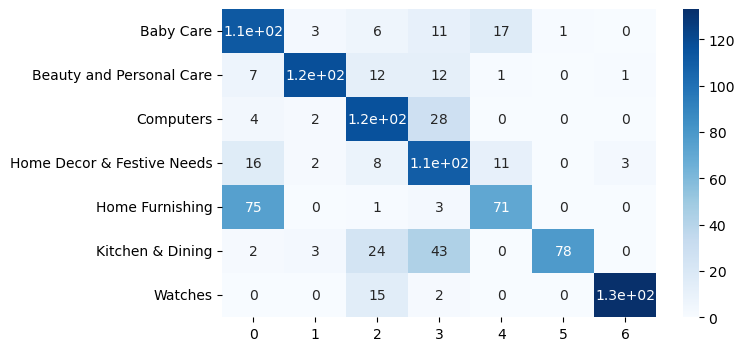

In [42]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

On constate qu'il existe des erreurs pour certains clusters mais d'autres semblent assez bien correspondre aux catégories, comme c'est le cas pour le cluster 1 qui semble correspondre à *Beauty and Personal Care*, le cluster 6 à *Watches* et le cluster 5 à *Kitchen & Dining*. Cela confirme les observations faites sur la représentation en 2D.


# <a id="7"></a> 3. Combinaison du traitement des données textuelles et des données visuelles

Nous récupérons les features calculés précédemment pour les données textuelles et pour les données visuelles. Nous décidons d'utiliser celles des modèles ayant présenté le meilleur ARI, à savoir USE pour les données textuelles et VGG16 pour les données visuelles.

In [104]:
features_USE.shape

(1050, 512)

In [105]:
images_features.shape

(1050, 4096)

In [106]:
df_features_USE = pd.DataFrame(features_USE)

In [107]:
df_images_features = pd.DataFrame(images_features)

In [108]:
df_img_text = pd.concat([df_features_USE,df_images_features], axis=1)
df_img_text

0         1         2         3         4         5         6      
0    -0.055396 -0.027823  0.018332  0.047501  0.030964  0.050779 -0.050235  \
1    -0.051229 -0.018987  0.012277  0.022975  0.057922  0.060340  0.057083   
2    -0.058108  0.021526 -0.044110  0.054895  0.056038  0.057703  0.049468   
3    -0.055624 -0.054227  0.046093  0.053195  0.055497  0.048124  0.014342   
4    -0.054780 -0.036940  0.040255  0.050871  0.054735  0.052953 -0.024609   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.043153  0.051357 -0.021462  0.037639  0.036713  0.039246 -0.041718   
1046 -0.064905 -0.015746 -0.001959  0.059259  0.036261  0.028397 -0.028893   
1047 -0.044080 -0.037559  0.030473  0.027353 -0.008345  0.045602 -0.072689   
1048 -0.046862 -0.039284  0.048987  0.052200  0.030195  0.045698 -0.069876   
1049 -0.055398 -0.024393  0.050927  0.040420  0.036196  0.050319 -0.070777   

          7         8         9     ...      4086  4087      4088      4089   
0     0.057108 -0.020648 -0.008976  ...  0.490016   0.0  0.000000  0.490314  \
1    -0.022221 -0.047319 -0.047699  ...  1.246728   0.0  0.000000  0.000000   
2     0.046216 -0.023052  0.003306  ...  0.000000   0.0  0.000000  0.000000   
3     0.027223 -0.013547 -0.052347  ...  0.000000   0.0  0.000000  0.000000   
4     0.049979  0.034676 -0.050614  ...  0.000000   0.0  0.000000  0.000000   
...        ...       ...       ...  ...       ...   ...       ...       ...   
1045  0.021651 -0.056601  0.058344  ...  0.000000   0.0  0.030518  0.000000   
1046  0.064954 -0.055086  0.050233  ...  0.000000   0.0  0.751143  0.791057   
1047  0.024444 -0.051943 -0.069020  ...  1.233734   0.0  0.000000  0.000000   
1048  0.031530 -0.011628 -0.070702  ...  0.961305   0.0  2.180539  2.697892   
1049  0.009188  0.001867 -0.077571  ...  0.000000   0.0  0.000000  0.880659   

          4090      4091      4092      4093      4094      4095  
0     0.867837  0.786626  0.000000  0.000000  0.865859  0.000000  
1     0.000000  3.110528  0.000000  0.000000  0.000000  0.000000  
2     0.000000  5.237411  0.000000  1.307143  0.000000  0.000000  
3     0.000000  3.959975  0.000000  0.000000  0.000000  0.000000  
4     0.000000  9.229384  0.168789  0.000000  1.707686  0.000000  
...        ...       ...       ...       ...       ...       ...  
1045  0.000000  0.000000  0.864257  1.107705  0.000000  0.000000  
1046  0.000000  1.059229  0.000000  1.504048  0.000000  1.004966  
1047  0.000000  0.216965  0.579521  2.170724  0.185214  0.000000  
1048  0.000000  0.000000  0.000000  0.000000  0.229054  0.922093  
1049  0.000000  2.338899  0.000000  0.000000  0.542270  2.969181  

[1050 rows x 4608 columns]

In [109]:
ARI_img_text, X_tsne_img_text, labels_img_text = fc.ARI_fct_tsne(df_img_text.values, liste_cat, df_cat["label"])

ARI :  0.4414 time :  4.0


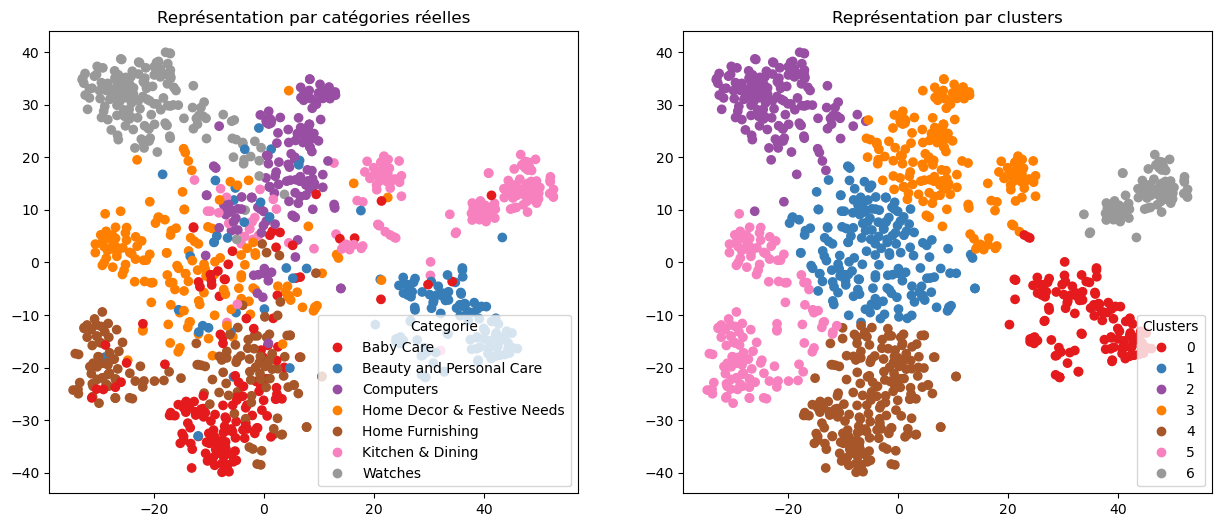

ARI :  0.4414


In [110]:
fc.TSNE_visu_fct(X_tsne_img_text, liste_cat, df_cat["label"], labels_img_text, ARI_img_text)

On constate toujours que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. En effet, la plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme *Watches* ou encore *Beauty and Personal Care*.

L'ARI est ici de 0.4414.

Nous allons donc réaliser une ACP afin de réduire nos dimensions puis ensuite réaliser un TSNE sur cette réduction.

**Réduction de dimension ACP :**

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%).
L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [111]:
print("Dimensions dataset avant réduction PCA : ", df_img_text.values.shape)
pca = PCA(n_components=0.99)
feat_pca_img_text = pca.fit_transform(df_img_text.values)
print("Dimensions dataset après réduction PCA : ", feat_pca_img_text.shape)

Dimensions dataset avant réduction PCA :  (1050, 4608)
Dimensions dataset après réduction PCA :  (1050, 803)


In [113]:
ARI_img_text2, X_tsne_img_text2, labels_img_text2 = fc.ARI_fct_tsne(feat_pca_img_text, liste_cat, df_cat["label"])

ARI :  0.4732 time :  4.0


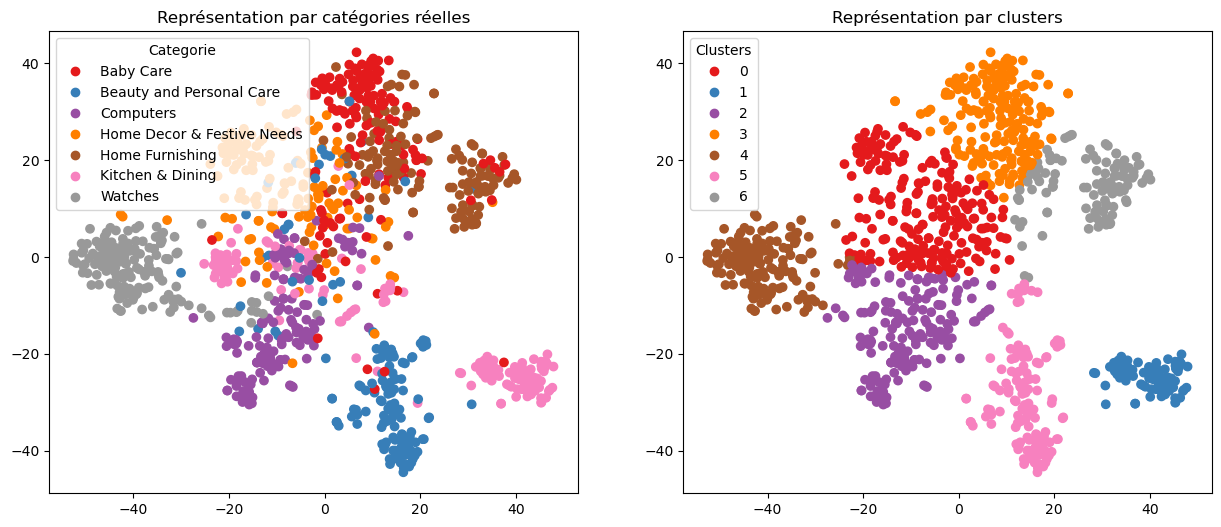

ARI :  0.4732


In [114]:
fc.TSNE_visu_fct(X_tsne_img_text2, liste_cat, df_cat["label"], labels_img_text2, ARI_img_text2)

On obtient une légère amélioration de l'ARI (0.4732) après avoir effectué une réduction de dimension via ACP puis une projection TSNE à 2 composantes.

On constate cependant toujours que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. La plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme celles évoquées précédemment.

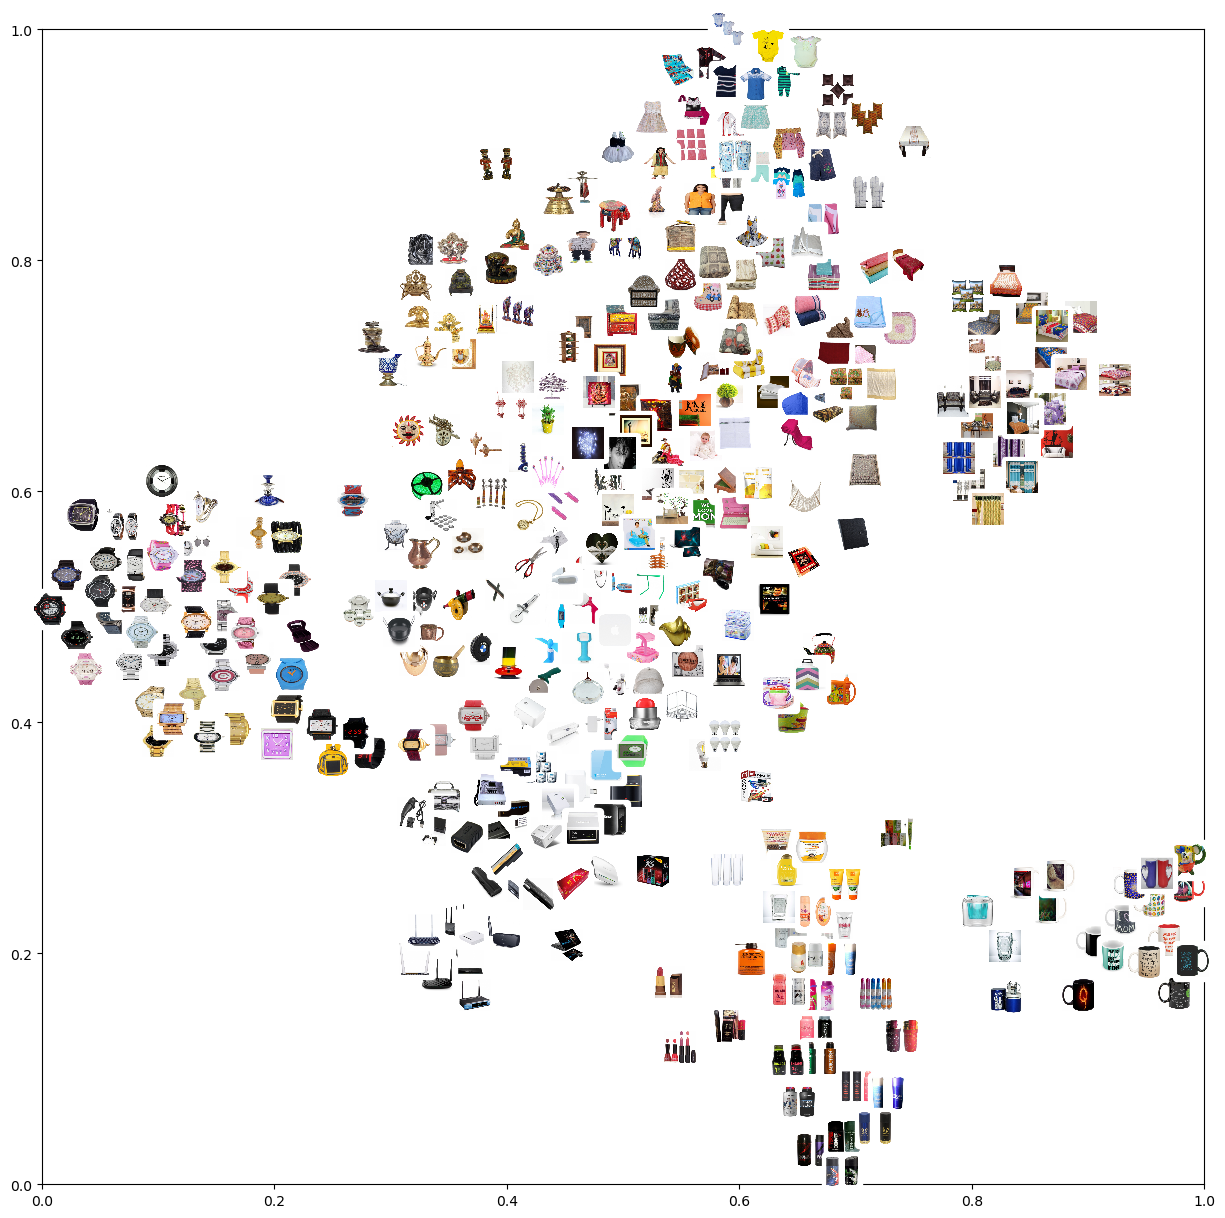

In [115]:
fc.plot_TSNE_images(X_tsne_img_text2, df_cat, path_images)

On affiche une partie des images sur la visualisation 2D avec les données TSNE calculées précédemment. On constate que certaines catégories sont bien regroupées et séparées à certains endroits. Par exemple, on retouve des montres à gauche, des produits de beauté en bas à droite, du matériel électronique au centre, des fournitures de maison à droite, des ustensils de cuisine en bas à droite, ou encore des produits pour bébés en haut. Au centre, les catégories sont mélangées, mais nous pouvons tout de même distinguer des regroupements.

In [121]:
tab_recap = pd.DataFrame({'ARI avec TSNE':[ARI_use, ARI_vgg, ARI_img_text],
                          'ARI avec PCA et TSNE': [ARI_use2, ARI_vgg2, ARI_img_text2]},
                          index = ['USE', 'VGG16','USE+VGG16']
                         )
tab_recap

ARI avec TSNE  ARI avec PCA et TSNE
USE               0.4342                0.4365
VGG16             0.4650                0.4327
USE+VGG16         0.4414                0.4732

On constate que la combinaison des features textuelles et visuelles ne donnent pas de meilleurs résultats pour l'ARI calculé après le TSNE mais en donne de meilleurs pour l'ARI après une réduction de dimension via ACP et un TSNE. En effet, l'ARI final est de 47.32%.

Pour conclure sur notre étude, nous pouvons déterminer que la faisabilité  d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article, est possible. 